# **Рекомендательная система для профпатологов. INSPECTRUM CLINIC.**
Цели. Тех. Задание

Цель:
Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.

Принцип работы:
Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.
Система может дополнять вердикт мнением, почему человек не годен, или почему ограниченно годен.

Требования интерфейсу:
Минимальный уровень реализации: notebook google colaboratory. Требуется реализовать простой веб-интерфейс для загрузки анализируемого моделью нейросети набора данных и удобным выводом результатов вынесенного решения.

Дополнительно: передача продвинутой системы веб-интерфейса, дополняющей вердикт мнением, почему человек не годен, или почему ограниченно годен.

Требования к скорости работы:
Не предъявляются

Требования к тестированию, метрикам качества:
Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.


# Подгружаем библиотеки, инструменты для работы, а также базу заказчика и дополнительную таблицу из приказа N29
Работа проводится в googlecolab\jupiter-nootbook

Обратите внимание на серьезную разбалансировку данных (несмотря на новый датасет кол-во примеров по классам все еще незначительно). Предсавителей класса - "Годен" больше всего в таблице, что вызывает затруднения в обучении НС (ей станет проще ставить везде "годен", чтобы получить высокую точность), при этом класса "НЕ ГОДЕН", как такового не существует, вместо него "ВременноНегоден". Также есть такие классы, как "НуждаетсяВДообследованииИЛечении", "ОграниченноГоден", "ГоденСКоррекциейЗрения" и др., что говорит об условности этих самых классов. Приказ РФ от 28 января 2021 г. N 29н содержит такую фразу "перечня медицинских противопоказаний к осуществлению работ с вредными и (или) опасными производственными факторами", а также не содержит таких слов как годен или негоден.
В любом случае по желанию заказчика система сделана под 3 класса, благодаря новым данным точность стала выше

In [ ]:
%matplotlib inline

import pandas as pd #табличные данные
import matplotlib.pyplot as plt #графики
from tensorflow.keras import utils #утилиты
from tensorflow.keras.models import Sequential, Model #модель
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, concatenate #слои
from tensorflow.keras.optimizers import Adam, Adadelta #оптимизаторы
from tensorflow.keras.metrics import Precision #метрики
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split #разделитель данных
from keras.layers import Embedding, Flatten
from keras.utils import to_categorical
import seaborn as sns
import numpy as np #нампи
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json #токенизатор

from sklearn.preprocessing import StandardScaler, LabelEncoder #может пригодиться

import time
import re

In [ ]:
from google.colab import drive #подключаю диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/NEW.xlsx') #читаем предоставленную таблицу заказчика

In [ ]:
df.head(3)

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп3_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,79292387-652a-11eb-80e7-0cc47aab8067,dca98d4e-2098-11ea-80d6-0cc47aab8067,1989-12-31 00:00:00,Женский,Женский,2021-02-02,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78efe744-9c36-11eb-80eb-0cc47aab8067,b35fb2bb-9c35-11eb-80eb-0cc47aab8067,1998-07-20 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131f68ef-9c2d-11eb-80eb-0cc47aab8067,f8c98e39-9c2c-11eb-80eb-0cc47aab8067,2002-01-04 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Получение уникальных значений и их количества по ключебому столбцу
unique_values = df['ЗаключениеМК'].unique()
count_values = df['ЗаключениеМК'].value_counts()

# Вывод уникальных значений и их количества
print("Уникальные значения:")
print(unique_values)
print("Количество каждого значения:")
print(count_values)

Уникальные значения:
['Годен' 'ГоденСКоррекциейЗрения' 'НуждаетсяВДообследованииИЛечении' nan
 'ГоденБезРаботНаВысотах' 'ГоденСКоррекциейСлуха' ' п. 11.3'
 'ОграниченноГоден' 'машинист бульдозера' 'Газоспасатель' ' Газоспасатель'
 'Негоден']
Количество каждого значения:
Годен                               17982
ГоденСКоррекциейЗрения               1114
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Газоспасатель                           2
 п. 11.3                                1
машинист бульдозера                     1
 Газоспасатель                          1
Name: ЗаключениеМК, dtype: int64


In [ ]:
# Задаем случайное семя для воспроизводимости результатов
np.random.seed(42)

# Генерируем маску для выбора строк с "Г" в колонке "ЗаключениеМК"
mask = (df['ЗаключениеМК'] == 'Годен')

# Получаем индексы строк, содержащих "Г"
indexes_to_remove = df[mask].index

# Случайно выбираем нужное количество индексов для удаления
indexes_to_remove = np.random.choice(indexes_to_remove, size=10000, replace=False)

# Удаляем строки с выбранными индексами
df = df.drop(indexes_to_remove)

In [ ]:
# Получение уникальных значений и их количества по ключебому столбцу
unique_values = df['ЗаключениеМК'].unique()
count_values = df['ЗаключениеМК'].value_counts()

# Вывод уникальных значений и их количества
print("Уникальные значения:")
print(unique_values)
print("Количество каждого значения:")
print(count_values)

Уникальные значения:
['Годен' 'ГоденСКоррекциейЗрения' 'НуждаетсяВДообследованииИЛечении' nan
 'ГоденБезРаботНаВысотах' 'ГоденСКоррекциейСлуха' ' п. 11.3'
 'ОграниченноГоден' 'машинист бульдозера' 'Газоспасатель' ' Газоспасатель'
 'Негоден']
Количество каждого значения:
Годен                               7982
ГоденСКоррекциейЗрения              1114
ГоденБезРаботНаВысотах                52
НуждаетсяВДообследованииИЛечении      40
ГоденСКоррекциейСлуха                  5
ОграниченноГоден                       4
Негоден                                3
Газоспасатель                          2
 п. 11.3                               1
машинист бульдозера                    1
 Газоспасатель                         1
Name: ЗаключениеМК, dtype: int64


In [ ]:
df.shape

(22686, 289)

In [ ]:
df.dropna(subset=['ЗаключениеМК'], inplace=True)

In [ ]:
df.shape

(9205, 289)

**Сохраняем предобработанную таблицу со сбалансированными данными**

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/Стажировка/NEW_Obrez.xlsx'
df.to_excel(filename, index=False)

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/NEW_Obrez.xlsx')

In [ ]:
df.head(3)

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп3_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,78efe744-9c36-11eb-80eb-0cc47aab8067,b35fb2bb-9c35-11eb-80eb-0cc47aab8067,1998-07-20 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,131f68ef-9c2d-11eb-80eb-0cc47aab8067,f8c98e39-9c2c-11eb-80eb-0cc47aab8067,2002-01-04 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5a24806c-f033-11eb-80f6-0cc47aab8067,52eb6a7d-c1ab-11ea-80dd-0cc47aab8067,1999-03-21 00:00:00,Женский,Женский,2021-07-29,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#mkb10 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/mkb10.xls')

In [ ]:
# Создание списка признаков для колонок
#mkb_features = list(set(mkb10['mkb_cod']))

# Создание датафрейма с пустыми значениями
#new_columns = pd.DataFrame(0, index=df.index, columns=mkb_features)

# Объединение новых колонок с исходным датафреймом
#df = pd.concat([df, new_columns], axis=1)

In [ ]:
#column_list = new_columns.columns.tolist()
#print(column_list)

In [ ]:
#len(column_list)

In [ ]:
#column_headers=column_list

In [ ]:
#for header in column_headers:
    # Проверка наличия заголовка столбца в каждой ячейке DataFrame
    #df[header] = df.apply(lambda row: 1 if header in row.values else 0, axis=1)

In [ ]:
#column_list = df.columns.tolist() #список столбцов
#print(column_list)

# **Загружаем новую обработанную таблицу из приказа н29**

Таблица была скопирована из приказа 29 и переделана под нашу конкретную задачу.

-коды мкб приведены к виду списка кодов вместо диапазона: А1-А3......A1, A2, A3

-Диапазоны вредных факторов и видов работ также приведены к новому виду вместо диапазона вредных факторов - их список в соответствии с перечнем приведенным в приказе: вместо -[1.30 - 1.33]..... -1.30, 1.30.1, 1.31, 1.32, 1.33

-добавлен новый столбец "класс"

-есть неприятная особенность - коды мкб выставлены в заголовки диапазоном (в приказе н29), и зачастую есть несоответствие кода и вредных факторов (он в том же диапазоне, но уже подходит под другие факторы), также есть подразделение одних и тех же кодов на легкие и тяжелые формы заболеваний, соответственно с разным перечнем вредных факторов и видов работ, что может определяться только врачом. Если бы была таблица с подробным подразделением по заболеваниям все было бы намного проще, но для этого нужен специалист по профпатологии, желательно профессионал, желательно мотивированный, моих знаний по терапии будет недостаточно для понимания всех нюансов, в любом случае со своей стороны, мне удалось перебрать таблицу и сопоставить некоторые диагнозы, коды мкб и вредные факторы так чтобы это не создавало проблем в работе модели и поддерживало высокую точность, при этом в таблице появляются новые случаи заболеваний которые редко встречаются в практике, но благодаря тому, что система их видела, модель выдвинет свою рекомендацию.

In [ ]:
dop_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/mkb10-auto2.xlsx') #читаем таблицу приказа n29 для последующей аугментации

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [ ]:
dop_data.head(3)

,mkb_cod,Вредные_факторы,Виды_работ
0,A00,NaN,"23, 24, 25, 26, 27"
1,A00.0,NaN,"23, 24, 25, 26, 27"
2,A00.1,NaN,"23, 24, 25, 26, 27"


In [ ]:
# Преобразуем значения в столбцах в строки
dop_data['Вредные_факторы'] = dop_data['Вредные_факторы'].astype(str)
dop_data['Виды_работ'] = dop_data['Виды_работ'].astype(str)

In [ ]:
dop_data['факторы'] = dop_data['Вредные_факторы'].fillna('') + ', ' + dop_data['Виды_работ']

In [ ]:
dop_data = dop_data.drop(['Вредные_факторы', 'Виды_работ'], axis=1)

In [ ]:
# Разделяем строку по запятым и удаляем значение NaN
dop_data['факторы'] = dop_data['факторы'].str.split(', ').apply(lambda x: ', '.join([i for i in x if i != 'nan']))

# Удаляем строки, где значение в столбце "факторы" является пустой строкой
dop_data = dop_data[dop_data['факторы'] != '']

In [ ]:
dop_data = dop_data.reset_index(drop=True)

In [ ]:
# Сохранение в файл Excel и дорабатываем вручную
dop_data.to_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29_NEW(for_change).xlsx', index=False)

In [ ]:
dop_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29_NEW(for_change).xlsx')

In [ ]:
dop_data

,mkb_cod,факторы
0,A00,"23, 24, 25, 26, 27"
1,A00.0,"23, 24, 25, 26, 27"
2,A00.1,"23, 24, 25, 26, 27"
3,A00.9,"23, 24, 25, 26, 27"
4,A01,"23, 24, 25, 26, 27"
...,...,...
6241,T98,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
6242,T98.0,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
6243,T98.1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
6244,T98.2,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."


In [ ]:
# Перемешиваем строки
dop_data_repeated_shuffled = dop_data.sample(frac=1).reset_index(drop=True)

In [ ]:
#проставим случайно профессии
import random

# Перечень профессий
professions = ['специалист', 'инженер', 'программист', 'машинист', 'администратор', 'лаборант',
    'бригадир', 'водитель', 'санитар', 'методист', 'кладовщик', 'маляр', 'бухгалтер', 'уборщик',
    'мастер', 'охранник', 'официант']

# Функция для выбора случайной профессии из перечня
def random_profession(row):
    if any(factor in row['факторы'] for factor in ['19', '23', '24', '25', '26', '27']):
            return random.choice(['повар', 'пекарь', 'кок', 'водопроводчик', 'воспитатель', 'учитель',
                                  'работник бытового обслуживания', 'медсестра', 'врач', 'сантехник', 'водолаз'])
    elif any(factor in row['факторы'] for factor in ['11', '12', '13']):
        return random.choice(['взрывник', 'нефтяник', 'вахтовик','бурильщиу'])
    elif any(factor in row['факторы'] for factor in ['4.1', '4.2']):
        return 'рентгенолог'
    elif row['факторы'] == '19':
        return 'водолаз'
    elif row['факторы'] == '5.2.2':
        return random.choice(['лектор', 'воспитатель', 'экскурсовод', 'гид'])
    else:
        return random.choice(professions)

# Применение функции к каждой строке
dop_data_repeated_shuffled['Профессия'] = dop_data_repeated_shuffled.apply(random_profession, axis=1)

In [ ]:
dop_data_repeated_shuffled['КлиентПол'] = None

In [ ]:
def set_random_gender():
    return random.choice([0, 1])

# Применение функции пола к каждой строке
dop_data_repeated_shuffled['КлиентПол'] = dop_data_repeated_shuffled['КлиентПол'].apply(lambda x: set_random_gender() if pd.isnull(x) else x)

In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения'] = None

In [ ]:
from datetime import datetime, timedelta

# Функция для генерации случайной даты в указанном диапазоне
def generate_random_date():
    start_date = datetime(1970, 1, 1)
    end_date = datetime(2004, 1, 1)

    random_days = random.randint(0, (end_date - start_date).days)
    random_date = start_date + timedelta(days=random_days)

    return random_date.strftime('%d.%m.%Y')

# Применение функции к каждой строке
dop_data_repeated_shuffled['КлиентДатаРождения'] = dop_data_repeated_shuffled['КлиентДатаРождения'].apply(lambda x: generate_random_date() if pd.isnull(x) else x)

In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения'] = pd.to_datetime(dop_data_repeated_shuffled['КлиентДатаРождения'], errors="coerce")
dop_data_repeated_shuffled["Возраст"] = \
    (pd.to_datetime("today") - dop_data_repeated_shuffled["КлиентДатаРождения"]).astype('<m8[Y]')

<ipython-input-37-6d75b1f623a1>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dop_data_repeated_shuffled['КлиентДатаРождения'] = pd.to_datetime(dop_data_repeated_shuffled['КлиентДатаРождения'], errors="coerce")


In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения']=dop_data_repeated_shuffled["Возраст"]

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.drop(columns='Возраст')

In [ ]:
dop_data_repeated_shuffled["КлиентДатаРождения"]=dop_data_repeated_shuffled["КлиентДатаРождения"].astype (int)

In [ ]:
dop_data_repeated_shuffled.head(3)

,mkb_cod,факторы,Профессия,КлиентПол,КлиентДатаРождения
0,H04.4,"1.1, 1.3, 1.5, 1.5.1, 1.6, 1.7, 1.7.1, 1.7.2, ...",врач,0,48
1,C31.3,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",сантехник,0,48
2,Q78.6,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",воспитатель,1,26


In [ ]:
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
dop_data_repeated_shuffled['ВозрастКатегория'] = dop_data_repeated_shuffled['КлиентДатаРождения'].apply(getParameterAgeVect)

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.drop(columns='КлиентДатаРождения')

In [ ]:
dop_data_repeated_shuffled['ЗаключениеМК'] = 1

In [ ]:
dop_data_repeated_shuffled.head(3)

,mkb_cod,факторы,Профессия,КлиентПол,ВозрастКатегория,ЗаключениеМК
0,H04.4,"1.1, 1.3, 1.5, 1.5.1, 1.6, 1.7, 1.7.1, 1.7.2, ...",врач,0,7,1
1,C31.3,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",сантехник,0,7,1
2,Q78.6,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",воспитатель,1,2,1


In [ ]:
dop_data_repeated_shuffled['факторы'].unique

<bound method Series.unique of 0       1.1, 1.3, 1.5, 1.5.1, 1.6, 1.7, 1.7.1, 1.7.2, ...
1       1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....
2       1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....
3       1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....
4       1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....
                              ...                        
6241                                               1.52.6
6242    1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....
6243    1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....
6244    1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....
6245    1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....
Name: факторы, Length: 6246, dtype: object>

# **ДАННЫЙ РАЗДЕЛ ТЕПЕРЬ НЕ ИСПОЛЬЗУЕТСЯ/Загружаем обработанную таблицу из приказа н29 и работаем с ней**
/Данный раздел больше не используется. Таблица перераотана вручную и видоизменена

Таблица была скопирована из приказа 29 и переделана под нашу конкретную задачу. Все действия были проделаны с таблицей вручную.

-коды мкб приведены к виду списка кодов вместо диапазона: А1-А3......A1, A2, A3

-оставлены только заголовки мкб: к примеру не "O99.1", а "O99". В дальнейшем можно изменить этот подход

-Диапазоны вредных факторов и видов работ также приведены к новому виду вместо диапазона вредных факторов - их список в соответствии с перечнем приведенным в приказе: вместо -[1.30 - 1.33]..... -1.30, 1.30.1, 1.31, 1.32, 1.33

-добавлен новый столбец "класс"

-есть неприятная особенность - коды мкб выставлены в заголовки диапазоном (в приказе н29), и зачастую есть несоответствие кода и вредных факторов (он в том же диапазоне, но уже подходит под другие факторы), также есть подразделение одних и тех же кодов на легкие и тяжелые формы заболеваний, соответственно с разным перечнем вредных факторов и видов работ, что может определяться только врачом. Если бы была таблица с подробным подразделением по заболеваниям все было бы намного проще, но для этого нужен специалист по профпатологии, желательно профессионал, желательно мотивированный, моих знаний по терапии будет недостаточно для понимания всех нюансов, в любом случае со своей стороны, мне удалось перебрать таблицу и сопоставить некоторые диагнозы, коды мкб и вредные факторы так чтобы это не создавало проблем в работе модели и поддерживало высокую точность, при этом в таблице появляются новые случаи заболеваний которые редко встречаются в практике, но благодаря тому, что система их видела, модель выдвинет свою рекомендацию.

In [ ]:
dop_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29.xlsx') #читаем таблицу приказа n29 для последующей аугментации

In [ ]:
#mkb_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/mkb10.xls') #читаем таблицу мкб

In [ ]:
#mkb_data.head(3)

In [ ]:
dop_data.head(3)

,Наименование_болезни,МКБ,Вредные_факторы,Виды_работ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК
0,Кишечные инфекции,"А00, А01, А02, А03, А04, А05, А06, А07, А08, А09",NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
1,Активный туберкулез органов дыхания; последств...,"А15, А16, А17, А18, А19","1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
2,Сифилис в заразном периоде,"А50, А51, А52, А53",NaN,"19, 19.1, 19.2, 19.3, 20, 21, 23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN


In [ ]:
# Разделение значений столбца "МКБ" по запятой
dop_data['МКБ'] = dop_data['МКБ'].str.split(', ')

# Дублирование строк с разделенными значениями столбца "МКБ"
dop_data = dop_data.explode('МКБ')

# Вывод полученной таблицы
#dop_data.head(15)

In [ ]:
dop_data.reset_index(drop=True)

,Наименование_болезни,МКБ,Вредные_факторы,Виды_работ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК
0,Кишечные инфекции,А00,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
1,Кишечные инфекции,А01,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
2,Кишечные инфекции,А02,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
3,Кишечные инфекции,А03,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
4,Кишечные инфекции,А04,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1856,"Последствия травм, отравлений, других воздейст...",Т94,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1857,"Последствия травм, отравлений, других воздейст...",Т95,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1858,"Последствия травм, отравлений, других воздейст...",Т96,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1859,"Последствия травм, отравлений, других воздейст...",Т97,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN


таким образом, как видно в таблице выше, я создаю новые случаи заболеваний и соответствующие им факторы риска-виды работ. Таблица требует доработки и экспертного взгяляда. Пока логичным будет создание 2 классов на большем кол-ве классов система будет часто ошибаться.

In [ ]:
# Преобразуем значения в столбцах в строки
dop_data['Вредные_факторы'] = dop_data['Вредные_факторы'].astype(str)
dop_data['Виды_работ'] = dop_data['Виды_работ'].astype(str)

In [ ]:
dop_data['факторы'] = dop_data['Вредные_факторы'].fillna('') + ', ' + dop_data['Виды_работ']

In [ ]:
dop_data = dop_data.drop(['Вредные_факторы', 'Виды_работ'], axis=1)

In [ ]:
# Разделяем строку по запятым и удаляем значение NaN
dop_data['факторы'] = dop_data['факторы'].str.split(', ').apply(lambda x: ', '.join([i for i in x if i != 'nan']))

# Удаляем строки, где значение в столбце "факторы" является пустой строкой
dop_data = dop_data[dop_data['факторы'] != '']

In [ ]:
dop_data = dop_data.reset_index(drop=True)

In [ ]:
#new_cells = mkb_data['mkb_cod'].tolist()

In [ ]:
# Преумножаем таблицу, сделав копии элементов
#dop_data_repeated = dop_data.loc[dop_data.index.repeat(3)].reset_index(drop=True)

In [ ]:
#dop_data_repeated.head(3)

In [ ]:
# Сохранение в файл Excel и дорабатываем вручную
dop_data.to_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29(for_change).xlsx', index=False)

In [ ]:
dop_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29(for_change).xlsx')

In [ ]:
# Перемешиваем строки
dop_data_repeated_shuffled = dop_data.sample(frac=1).reset_index(drop=True)

In [ ]:
#проставим случайно профессии
import random

# Перечень профессий
professions = ['специалист', 'инженер', 'программист', 'машинист', 'администратор', 'лаборант',
    'бригадир', 'водитель', 'санитар', 'методист', 'кладовщик', 'маляр', 'бухгалтер', 'уборщик',
    'мастер', 'охранник', 'официант']

# Функция для выбора случайной профессии из перечня
def random_profession(row):
    if any(factor in row['факторы'] for factor in ['19', '23', '24', '25', '26', '27']):
            return random.choice(['повар', 'пекарь', 'кок', 'водопроводчик', 'воспитатель', 'учитель',
                                  'работник бытового обслуживания', 'медсестра', 'врач', 'сантехник', 'водолаз'])
    elif any(factor in row['факторы'] for factor in ['11', '12', '13']):
        return random.choice(['взрывник', 'нефтяник', 'вахтовик','бурильщиу'])
    elif any(factor in row['факторы'] for factor in ['4.1', '4.2']):
        return 'рентгенолог'
    elif row['факторы'] == '19':
        return 'водолаз'
    elif row['факторы'] == '5.2.2':
        return random.choice(['лектор', 'воспитатель', 'экскурсовод', 'гид'])
    else:
        return random.choice(professions)

# Применение функции к каждой строке
dop_data_repeated_shuffled['Профессия'] = dop_data_repeated_shuffled.apply(random_profession, axis=1)

In [ ]:
# Функция для выбора цеха
def set_workshop(row):
    profession = row['Профессия']
    if profession in ['врач', 'медсестра', 'санитар', 'рентгенолог']:
        return random.choice(['поликлиника', 'больница'])
    elif profession in ['повар', 'пекарь', 'кок']:
        return random.choice(['кухня', 'столовая', 'кафе'])
    elif profession in ['сантехник', 'работник бытового обслуживания', 'водопроводчик']:
        return 'Административно-хозяйственный'
    elif profession in ['воспитатель', 'учитель', 'лектор']:
        return random.choice(['училище', 'детский сад', 'университет', 'школа'])
    # Добавьте остальные условия для остальных профессий и соответствующих цехов
    else:
        return row['Цех']

# Применение функции к каждой строке
dop_data_repeated_shuffled['Цех'] = dop_data_repeated_shuffled.apply(set_workshop, axis=1)

**Это примерная функция для подстановки конкретной профессии и цеха конкретному виду работ. к примеру подставив профессии 'повар', 'пекарь', 'кок' к строкам с парами вредный фактор-диагноз, которые препятствуют такой работе, мы получим явное несоответствие пациента исполняемым трудовым обязательствам**

In [ ]:
def set_random_gender():
    return random.choice([0, 1])

# Применение функции пола к каждой строке
dop_data_repeated_shuffled['КлиентПол'] = dop_data_repeated_shuffled['КлиентПол'].apply(lambda x: set_random_gender() if pd.isnull(x) else x)

In [ ]:
from datetime import datetime, timedelta

# Функция для генерации случайной даты в указанном диапазоне
def generate_random_date():
    start_date = datetime(1970, 1, 1)
    end_date = datetime(2004, 1, 1)

    random_days = random.randint(0, (end_date - start_date).days)
    random_date = start_date + timedelta(days=random_days)

    return random_date.strftime('%d.%m.%Y')

# Применение функции к каждой строке
dop_data_repeated_shuffled['КлиентДатаРождения'] = dop_data_repeated_shuffled['КлиентДатаРождения'].apply(lambda x: generate_random_date() if pd.isnull(x) else x)

In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения'] = pd.to_datetime(dop_data_repeated_shuffled['КлиентДатаРождения'], errors="coerce")
dop_data_repeated_shuffled["Возраст"] = \
    (pd.to_datetime("today") - dop_data_repeated_shuffled["КлиентДатаРождения"]).astype('<m8[Y]')

<ipython-input-69-6d75b1f623a1>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dop_data_repeated_shuffled['КлиентДатаРождения'] = pd.to_datetime(dop_data_repeated_shuffled['КлиентДатаРождения'], errors="coerce")


In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения']=dop_data_repeated_shuffled["Возраст"]

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.drop(columns='Возраст')

In [ ]:
dop_data_repeated_shuffled["КлиентДатаРождения"]=dop_data_repeated_shuffled["КлиентДатаРождения"].astype (int)

In [ ]:
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
dop_data_repeated_shuffled['ВозрастКатегория'] = dop_data_repeated_shuffled['КлиентДатаРождения'].apply(getParameterAgeVect)

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.drop(columns='КлиентДатаРождения')

In [ ]:
dop_data_repeated_shuffled['ЗаключениеМК'] = 1

# **Работаем с таблицей заказчика. очистка данных от мусора. добавление новых данных в соответствии с приказом**

In [ ]:
df_1 = df.dropna(axis=0, how='all') #удаляем пустые строки и столбцы
df_2 = df_1.dropna(axis=1, how='all')

In [ ]:
column_list = df_2.columns.tolist()

In [ ]:
df_list_1 = [] #создаем список колонок содержащих КОД МКБ
for i in column_list:
  if "МКБ" in i:
    df_list_1.append(i)

In [ ]:
print(df_list_1)

['Гинекология1_МКБ101', 'Гинекология1_МКБ102', 'Гинекология1_МКБ103', 'Гинекология2_МКБ101', 'Гинекология2_МКБ102', 'Гинекология2_МКБ103', 'Гинекология3_МКБ101', 'Гинекология3_МКБ102', 'Гинекология3_МКБ103', 'Гинекология4_МКБ101', 'Гинекология4_МКБ102', 'ГинекологНеИсп1_МКБ101', 'Дерматовенерология1_МКБ101', 'Дерматовенерология1_МКБ102', 'Дерматовенерология1_МКБ103', 'Дерматовенерология2_МКБ101', 'Дерматовенерология2_МКБ102', 'Дерматовенерология2_МКБ103', 'Дерматовенерология3_МКБ101', 'Дерматовенерология3_МКБ102', 'Дерматовенерология3_МКБ103', 'Дерматовенерология4_МКБ101', 'Дерматовенерология4_МКБ102', 'ДерматовенерологНеИсп1_МКБ101', 'ЛабораторнаяДиагностика1_МКБ101', 'ЛабораторныеИсследования1_МКБ101', 'ЛабораторныеИсследования1_МКБ102', 'ЛабораторныеИсследования1_МКБ103', 'ЛабораторныеИсследования2_МКБ101', 'ЛабораторныеИсследования2_МКБ102', 'ЛабораторныеИсследования2_МКБ103', 'ЛабораторныеИсследования3_МКБ101', 'ЛабораторныеИсследования3_МКБ102', 'ЛабораторныеИсследования3_МКБ103'

_______________________________

In [ ]:
#df_list_di = [] #создаем список колонок с ДИАГНОЗОМ В ТЕКСТЕ
#for i in column_list:
#  if "Диагноз_ЗначениеПредставление" in i:
#    df_list_di.append(i)

In [ ]:
#print(df_list_di)

_______________________________

______________________

# **Поработаем с текстовым представлением диагноза**
Данный раздел из за отсутствующих данных в новом датасете стал неактуальным. В данном разделе мы создаем единый столбец всех текстовых диагнозов, попутно убирая дубликаты и мусор, и оставляя только значимый диагноз если имеются диагнозы кроме Z00

Делается сводный столбец со всеми диагнозами. одинаковые-дублирующие друг друга данные убираются.

In [ ]:
#df2_DI=df_2[df_list_di]

In [ ]:
#df2_DI.head(2)

In [ ]:
# Удаление повторяющихся значений в столбцах
#df2_DI = df2_DI.replace("_x000D_\\n", " ", regex=True).replace("nan", " ", regex=True)

In [ ]:
#df2_DI = df2_DI.astype(str)

In [ ]:
# Функция для удаления значений в квадратных скобках из строки
#def remove_brackets(text):
#    return re.sub(r'\[.*?\]', ' ', text)

# Применение функции к каждой ячейке в DataFrame
#df2_DI = df2_DI.applymap(remove_brackets)

In [ ]:
#def combine_values(row):
#    combined_values = ','.join(row.dropna().astype(str).str.strip().unique())
#    return combined_values

# Применение функции к каждой строке таблицы
#df2_DI['Диагноз_текстом'] = df2_DI.apply(combine_values, axis=1)

#df2_DI

In [ ]:
#df2_DI = df2_DI.drop(columns=df_list_di)

In [ ]:
#df2_DI

In [ ]:
#df2_DI['Диагноз_текстом'] = df2_DI['Диагноз_текстом'].fillna('').str.replace('nan', '').str.strip(',')

In [ ]:
#df2_DI = df2_DI.replace(',,,', ',', regex=True)

In [ ]:
#df2_DI = df2_DI.replace(',,', ',', regex=True)

In [ ]:
#def remove_Ob_med(row):
#    values = row.split(',')
#    if 'Общий медицинский осмотр' in values and len(values) > 1:
#        values.remove('Общий медицинский осмотр')
#    return ','.join(values)

#df2_DI['Диагноз_текстом'] = df2_DI['Диагноз_текстом'].apply(remove_Ob_med)

In [ ]:
#df2_DI

In [ ]:
#df2_DI = df2_DI.replace(',', ', ', regex=True)

In [ ]:
#unique_values = df2_DI['Диагноз_текстом'].unique()

# Вывод уникальных значений
#print(unique_values)

Таким образом при помощи кода выше мы объединяем столбцы в единый по текстовому описанию диагноза и уничтажаем "Общий медицинский осмотр", если и так есть серьезный диагноз, во избежание путаницы. В остальных случаях, когда в столбце только представители класса "Общий медицинский осмотр", он останется.

__________________________________

# **Поработаем с МКБ**
В данном разделе мы очищаем столбцы от мусора, объединяем столбцы с мкб в один попутно убирая дубликаты и оставляя только значимые диагнозы (отличные от Z00)

одинаковые-дублирующие друг друга данные убираются. Делается сводный столбец со всеми кодами МКБ выставленными узкими специалистами

In [ ]:
df2_MKB=df_2[df_list_1]

In [ ]:
#for column in df2_MKB.columns:
    # Применение метода str.extract() с регулярным выражением для извлечения значений до точки
    #df2_MKB[column] = df2_MKB[column].str.extract(r'([^.]*)')

In [ ]:
df2_MKB

,Гинекология1_МКБ101,Гинекология1_МКБ102,Гинекология1_МКБ103,Гинекология2_МКБ101,Гинекология2_МКБ102,Гинекология2_МКБ103,Гинекология3_МКБ101,Гинекология3_МКБ102,Гинекология3_МКБ103,Гинекология4_МКБ101,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df2_MKB=df2_MKB.astype(str)

In [ ]:
def combine_values(row):
    combined_values = ','.join(row.dropna().astype(str).str.strip().unique())
    return combined_values

# Применение функции к каждой строке таблицы
df2_MKB['МКБ'] = df2_MKB.apply(combine_values, axis=1)

In [ ]:
df2_MKB = df2_MKB.drop(columns=df_list_1)

In [ ]:
df2_MKB['МКБ'] = df2_MKB['МКБ'].fillna('').str.replace('nan', '').str.strip(',')

In [ ]:
df2_MKB

,МКБ
0,Z00.0
1,Z00.0
2,Z00.0
3,Z00.0
4,"Z00.0,K29.9"
...,...
9200,
9201,
9202,
9203,


In [ ]:
df2_MKB = df2_MKB.replace(',,', ',', regex=True)

In [ ]:
def remove_z00(row):
    values = row.split(',')
    if 'Z00.0' in values and len(values) > 1:
        values.remove('Z00.0')
    return ','.join(values)

df2_MKB['МКБ'] = df2_MKB['МКБ'].apply(remove_z00)

In [ ]:
df2_MKB

,МКБ
0,Z00.0
1,Z00.0
2,Z00.0
3,Z00.0
4,K29.9
...,...
9200,
9201,
9202,
9203,


In [ ]:
df2_MKB = df2_MKB.replace(',', ', ', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("\[",'', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("\]",'', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("Амбулаторная помощь при необходимости,",'', regex=True)

In [ ]:
unique_values = df2_MKB['МКБ'].unique()

# Вывод уникальных значений
print(unique_values.tolist())

['Z00.0', 'K29.9', 'I11.9', 'H52.1', 'H11.0', 'H52.0, I11.9', 'I11.9, K29.6', 'H52.2', 'K29.3', 'H52.0, I49', 'H52.0', 'H52.1, I11.9', 'M42.1, H52.1', '', 'H30, I11.9', 'H53.0, I11.9', 'H90.3, I11.9', 'I11.9, K29.3', 'G25.0, I11.9', 'K20', 'G90.8', 'K29.8', 'G90.9', 'E66, K29.9, K76.0', 'J45', 'D25, I11.9', 'Н27, I11.9', 'H25, F06.8, F10.3, I11.9', 'I11.9, I83.9', 'H31.0, I11.9', 'H90.3', 'J45.9', 'M51.1', 'H90.4, H52.0', 'H52.1, H52.2', 'H52.0, I12.9, I11.9', 'I11.9, I25.9', 'H74.1, I11.9', 'J30.2', 'H11.0, I11.9', 'H52.0, I49.9', 'R25.1, I25.2, I11.9', 'L30.0, H52.2', 'G25.1', 'J32.0', 'H02.0', 'H50.0', 'I11.9, I25.8', 'T90.4, H52.1', 'H52.1, K80.1', 'L40.9, H52.1', 'H52.2, I11.9', 'I11.9, I25.0', 'H50.8, H52.1', 'H52.1, H53.5', 'H52.0, I11.9, J45.0', 'I69.3, H52.1, I11.9', 'K80.1', 'I11.9, I44.4', 'H52.0, I11.9, K29.6', 'K04.5', 'H52.0, H52.4', 'H52.1, K26.7', 'H52.1, H52.2, K26.7', 'K29.6', 'H74.1', 'K83.8', 'H52.1, K29.3', 'H52.1, Q13.0', 'H52.0, K29.9', 'H50.1, H52.1, H52.2', 'K2

In [ ]:
df2_MKB['МКБ'] = df2_MKB['МКБ'].replace('', np.nan)

In [ ]:
unique_values = df2_MKB['МКБ'].unique()

# Вывод уникальных значений
print(unique_values.tolist())

['Z00.0', 'K29.9', 'I11.9', 'H52.1', 'H11.0', 'H52.0, I11.9', 'I11.9, K29.6', 'H52.2', 'K29.3', 'H52.0, I49', 'H52.0', 'H52.1, I11.9', 'M42.1, H52.1', nan, 'H30, I11.9', 'H53.0, I11.9', 'H90.3, I11.9', 'I11.9, K29.3', 'G25.0, I11.9', 'K20', 'G90.8', 'K29.8', 'G90.9', 'E66, K29.9, K76.0', 'J45', 'D25, I11.9', 'Н27, I11.9', 'H25, F06.8, F10.3, I11.9', 'I11.9, I83.9', 'H31.0, I11.9', 'H90.3', 'J45.9', 'M51.1', 'H90.4, H52.0', 'H52.1, H52.2', 'H52.0, I12.9, I11.9', 'I11.9, I25.9', 'H74.1, I11.9', 'J30.2', 'H11.0, I11.9', 'H52.0, I49.9', 'R25.1, I25.2, I11.9', 'L30.0, H52.2', 'G25.1', 'J32.0', 'H02.0', 'H50.0', 'I11.9, I25.8', 'T90.4, H52.1', 'H52.1, K80.1', 'L40.9, H52.1', 'H52.2, I11.9', 'I11.9, I25.0', 'H50.8, H52.1', 'H52.1, H53.5', 'H52.0, I11.9, J45.0', 'I69.3, H52.1, I11.9', 'K80.1', 'I11.9, I44.4', 'H52.0, I11.9, K29.6', 'K04.5', 'H52.0, H52.4', 'H52.1, K26.7', 'H52.1, H52.2, K26.7', 'K29.6', 'H74.1', 'K83.8', 'H52.1, K29.3', 'H52.1, Q13.0', 'H52.0, K29.9', 'H50.1, H52.1, H52.2', 'K

Таким образом как вы видете выше. Мы получаем столбец с "чистым мкб". Убираются все дубликаты кода МКБ, к примеру если имеем множество из Z00, зачем нам такое множество? Или если есть Z00 и серьезный диагноз оставляем только серьезный диагноз или список серьезных диагнозов в ячейке

# **Объединяем разобранные по отдельности разделы, а также редактируем вредные факторы-виды работ, где вместо них стоит дата**

In [ ]:
df4=df[[
  'КлиентДатаРождения',
  'КлиентПол',
  'Профессия',
  'ЗаключениеМК',
  'ВредныеФакторы']]

In [ ]:
df_full=pd.concat([df4, df2_MKB], axis=1, sort=False)

In [ ]:
df_full.fillna(0, inplace=True)

In [ ]:
df_full

,КлиентДатаРождения,КлиентПол,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ
0,1998-07-20 00:00:00,Женский,Продавец-кассир,Годен,04.окт,Z00.0
1,2002-01-04 00:00:00,Женский,Младший продавец-консультант,Годен,23,Z00.0
2,1999-03-21 00:00:00,Женский,Продавец-кассир,Годен,23,Z00.0
3,1996-02-06 00:00:00,Женский,Педагог,Годен,25,Z00.0
4,1992-06-14 00:00:00,Мужской,Монтажник технологических трубопроводов,Годен,"4.4,5.1,15,6.1,11.4",K29.9
...,...,...,...,...,...,...
9200,1979-11-30 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9201,1976-07-13 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9202,1992-04-28 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9203,1980-03-18 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0


**В таблице заказчика есть неправильные данные в столбце вредных факторов -  даты вместо вредного фактора, попробуем это исправить для того чтобы не упустить нужные строки, загрузим предобработанный словарь**

In [ ]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/Стажировка/для_исправления_дат.json') as file:
    data = json.load(file)

In [ ]:
df_full['ВредныеФакторы'] = df_full['ВредныеФакторы'].replace(data)

In [ ]:
df_full

,КлиентДатаРождения,КлиентПол,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ
0,1998-07-20 00:00:00,Женский,Продавец-кассир,Годен,4.10,Z00.0
1,2002-01-04 00:00:00,Женский,Младший продавец-консультант,Годен,23,Z00.0
2,1999-03-21 00:00:00,Женский,Продавец-кассир,Годен,23,Z00.0
3,1996-02-06 00:00:00,Женский,Педагог,Годен,25,Z00.0
4,1992-06-14 00:00:00,Мужской,Монтажник технологических трубопроводов,Годен,"4.4,5.1,15,6.1,11.4",K29.9
...,...,...,...,...,...,...
9200,1979-11-30 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9201,1976-07-13 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9202,1992-04-28 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9203,1980-03-18 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0


In [ ]:
df_full = df_full.replace(' nan ', ' ', regex=True)

In [ ]:
df_full = df_full.replace(' nan', ' ', regex=True)

In [ ]:
df_full = df_full.replace('nan ', ' ', regex=True)

In [ ]:
df_full = df_full.replace('', '0', regex=True)

In [ ]:
df_full = df_full.replace('nan', '0', regex=True)

In [ ]:
df_full_1=df_full.dropna(subset=['ЗаключениеМК'])

In [ ]:
df_full_1

,КлиентДатаРождения,КлиентПол,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ
0,1998-07-20 00:00:00,Женский,Продавец-кассир,Годен,4.10,Z00.0
1,2002-01-04 00:00:00,Женский,Младший продавец-консультант,Годен,23,Z00.0
2,1999-03-21 00:00:00,Женский,Продавец-кассир,Годен,23,Z00.0
3,1996-02-06 00:00:00,Женский,Педагог,Годен,25,Z00.0
4,1992-06-14 00:00:00,Мужской,Монтажник технологических трубопроводов,Годен,"4.4,5.1,15,6.1,11.4",K29.9
...,...,...,...,...,...,...
9200,1979-11-30 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9201,1976-07-13 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9202,1992-04-28 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0
9203,1980-03-18 00:00:00,Мужской,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",0


In [ ]:
df_full_1.drop(df_full_1[df_full_1['МКБ'] == 0].index, inplace=True)

In [ ]:
df_full_1

,КлиентДатаРождения,КлиентПол,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ
0,1998-07-20 00:00:00,Женский,Продавец-кассир,Годен,4.10,Z00.0
1,2002-01-04 00:00:00,Женский,Младший продавец-консультант,Годен,23,Z00.0
2,1999-03-21 00:00:00,Женский,Продавец-кассир,Годен,23,Z00.0
3,1996-02-06 00:00:00,Женский,Педагог,Годен,25,Z00.0
4,1992-06-14 00:00:00,Мужской,Монтажник технологических трубопроводов,Годен,"4.4,5.1,15,6.1,11.4",K29.9
...,...,...,...,...,...,...
9180,1978-06-26 00:00:00,Мужской,Водитель,Годен,18.2,I11.9
9181,1978-02-09 00:00:00,Женский,Обвальщица,ГоденСКоррекциейЗрения,5.1,H52.1
9182,1964-08-05 00:00:00,Женский,Обвальщик мясного цеха,НуждаетсяВДообследованииИЛечении,23,"I11.9, R73.9"
9183,1969-03-02 00:00:00,Мужской,Начальник участка,Годен,"1.50,4.2.5,4.3,4.4,5.1,6.1",Z00.0


In [ ]:
df_full_1['КлиентДатаРождения'] = pd.to_datetime(df_full_1['КлиентДатаРождения'], errors="coerce")
df_full_1["Возраст"] = \
    (pd.to_datetime("today") - df_full_1["КлиентДатаРождения"]).astype('<m8[Y]')

In [ ]:
df_full_1['КлиентДатаРождения']=df_full_1["Возраст"]

In [ ]:
df_full_1 = df_full_1.drop(columns='Возраст')

In [ ]:
df_full_1.loc[df_full_1['КлиентПол'] == "Женский", 'КлиентПол'] = 0
df_full_1.loc[df_full_1['КлиентПол'] == "Мужской", 'КлиентПол'] = 1

In [ ]:
df_full_1.dropna(subset=['КлиентДатаРождения'], inplace=True)

In [ ]:
df_full_1["КлиентДатаРождения"]=df_full_1["КлиентДатаРождения"].astype (int)

In [ ]:
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
df_full_1['ВозрастКатегория'] = df_full_1['КлиентДатаРождения'].apply(getParameterAgeVect)

In [ ]:
df_full_1 = df_full_1.drop(columns='КлиентДатаРождения')

In [ ]:
df_full_1["ЗаключениеМК"].unique ()

array(['Годен', 'ГоденСКоррекциейЗрения',
       'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах',
       'ГоденСКоррекциейСлуха', 'ОграниченноГоден', 'машинист бульдозера',
       'Газоспасатель', ' Газоспасатель', 'Негоден'], dtype=object)

In [ ]:
values_to_remove = ["машинист бульдозера", "Газоспасатель", " Газоспасатель", " Газоспасатель", "0", " п. 11.3", 0]

# Удалить строки, содержащие значения из списка values_to_remove
new = df_full_1[~df_full_1['ЗаключениеМК'].isin(values_to_remove)]

In [ ]:
new["ЗаключениеМК"].unique()

array(['Годен', 'ГоденСКоррекциейЗрения',
       'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах',
       'ГоденСКоррекциейСлуха', 'ОграниченноГоден', 'Негоден'],
      dtype=object)

In [ ]:
class_counts = new["ЗаключениеМК"].value_counts()
print(class_counts)

Годен                               6230
ГоденСКоррекциейЗрения              1107
ГоденБезРаботНаВысотах                51
НуждаетсяВДообследованииИЛечении      39
ГоденСКоррекциейСлуха                  5
ОграниченноГоден                       3
Негоден                                3
Name: ЗаключениеМК, dtype: int64


In [ ]:
#new = new.drop(new[new["ЗаключениеМК"] == 0].index)

In [ ]:
new.loc[new['ЗаключениеМК'] == "Годен", 'ЗаключениеМК'] = "Г"
new.loc[new['ЗаключениеМК'] == "ГоденСКоррекциейЗрения", 'ЗаключениеМК'] = "ОГ"
new.loc[new['ЗаключениеМК'] == "ГоденБезРаботНаВысотах", 'ЗаключениеМК'] = "ОГ"
new.loc[new['ЗаключениеМК'] == "НуждаетсяВДообследованииИЛечении", 'ЗаключениеМК'] = "ВНГ/НГ" # так как на данный момент нельзя сказать что годен
new.loc[new['ЗаключениеМК'] == "ВременноНегоден", 'ЗаключениеМК'] = "ВНГ/НГ"
new.loc[new['ЗаключениеМК'] == "ОграниченноГоден", 'ЗаключениеМК'] = "ОГ"
new.loc[new['ЗаключениеМК'] == "ГоденСКоррекциейСлуха", 'ЗаключениеМК'] = "ОГ"
new.loc[new['ЗаключениеМК'] == "Негоден", 'ЗаключениеМК'] = "ВНГ/НГ"

In [ ]:
class_counts = new["ЗаключениеМК"].value_counts()
print(class_counts)

Г         6230
ОГ        1166
ВНГ/НГ      42
Name: ЗаключениеМК, dtype: int64


In [ ]:
# Задаем случайное семя для воспроизводимости результатов
#np.random.seed(42)

# Генерируем маску для выбора строк с "Г" в колонке "ЗаключениеМК"
#mask = (new['ЗаключениеМК'] == 'Г')

# Получаем индексы строк, содержащих "Г"
#indexes_to_remove = new[mask].index

# Случайно выбираем нужное количество индексов для удаления
#indexes_to_remove = np.random.choice(indexes_to_remove, size=15504, replace=False)

# Удаляем строки с выбранными индексами
#new = new.drop(indexes_to_remove)

In [ ]:
duplicates = new[new['ЗаключениеМК'] == 'ОГ'].copy()

In [ ]:
# Объединяем исходный датасет с дубликатами
new_dup = pd.concat([new, duplicates], ignore_index=True)

In [ ]:
new_dup = pd.concat([new_dup, duplicates], ignore_index=True)

In [ ]:
new_dup = pd.concat([new_dup, duplicates], ignore_index=True)

In [ ]:
new_dup = pd.concat([new_dup, duplicates], ignore_index=True)

In [ ]:
class_counts = new_dup["ЗаключениеМК"].value_counts()
print(class_counts)

Г         6230
ОГ        5830
ВНГ/НГ      42
Name: ЗаключениеМК, dtype: int64


In [ ]:
#new_repeated = new.loc[new.index.repeat(3)].reset_index(drop=True)

In [ ]:
#new_repeated

In [ ]:
column_list = new_dup.columns.tolist()
column_list

['КлиентПол',
 'Профессия',
 'ЗаключениеМК',
 'ВредныеФакторы',
 'МКБ',
 'ВозрастКатегория']

In [ ]:
column_list_2 = dop_data_repeated_shuffled.columns.tolist()
column_list_2

['Наименование_болезни',
 'МКБ',
 'Цех',
 'Профессия',
 'КлиентПол',
 'ЗаключениеМК',
 'факторы',
 'ВозрастКатегория']

In [ ]:
dop_data_repeated_shuffled.rename(columns={'mkb_cod': 'МКБ'}, inplace=True)
dop_data_repeated_shuffled.rename(columns={'факторы': 'ВредныеФакторы'}, inplace=True)

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.reindex(columns=column_list)

In [ ]:
dop_data_repeated_shuffled["ЗаключениеМК"] = "ВНГ/НГ"

In [ ]:
combined_df = pd.concat([new_dup, dop_data_repeated_shuffled], ignore_index=True)


In [ ]:
class_counts = combined_df["ЗаключениеМК"].value_counts()
print(class_counts)

Г         6230
ОГ        5830
ВНГ/НГ    1903
Name: ЗаключениеМК, dtype: int64


In [ ]:
# Перемешиваем строки
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

In [ ]:
combined_df['ВредныеФакторы'] = combined_df['ВредныеФакторы'].str.replace(' ', '')

In [ ]:
combined_df.shape

(13963, 6)

In [ ]:
combined_df = combined_df.dropna(subset=["ВредныеФакторы"])

In [ ]:
unique_factors = combined_df["ВредныеФакторы"].unique().tolist()
print(unique_factors)

['4.4,5.1,6.2,11.1,11.4', '23,18.1', '8,18.2', '1.15,4.4,4.7,12,17', '23', '1.1,1.2,1.6,1.8.1,1.8.1.1,1.8.1.2,1.8.2,1.8.2.1,1.8.2.2,1.8.3,1.13,1.14,1.14.1,1.14.2,1.15,1.15.1,1.16,1.17,1.22,1.26,1.29.5,1.35,1.36.1,1.36.2,1.37.1.2,1.38,1.39,1.40,1.40.1,1.40.2,1.41,1.42,1.43.1,1.44,1.45.1,1.45.2,1.46,1.47.1,1.47.2,1.49,1.49.1,1.49.2,1.49.3,1.49.4,1.49.5,1.49.6,1.49.7,1.49.8,1.49.9,1.49.10,1.49.11,1.49.12,1.49.13,1.49.14,1.50,1.51,1.52.1,1.52.2,1.52.3,1.52.4,1.52.5,1.52.7,2,3.1.7,3.1.8.2,3.1.8.3,3.1.9,3.1.10,3.4,10,11,13,14,16,17,19,19.1,19.2,19.3,20,21', '4.7,11.1,4.2.5', '4.2.5,11.1,18.1', '4.2.5,6.1,9', '1.5', '6.2,9,11.1,18.1', '25', '1.5.1,4.2.5,5.1,6,6.1,6.2,13,17', '6.1,9,15', '4.1,5.1,6.1,11.1', '23,24', '1.1,1.17,1.23,1.39,4.2.1,4.4,5.1,6.1,11.4', '4.2.5,10,11.1,11.4', '3.1.2,4.3.1,4.4,5.1,11.4,6.2', '4.4,5.1,26', '1.29.2,4.1,4.2.5,4.4,6.2,11.1,4.7', '1.30.1,4.1,4.2.5,4.3.2,4.4,4.7,6.2,11.1,11.4,13,17,18.1,18.2', '4.2.5,11.1,11.4', '1.23,23', '4.4,5.1,6.1,11.1,15', '8,11.1,11.4,18

In [ ]:
combined_df["ВредныеФакторы"] = combined_df["ВредныеФакторы"].astype(str)

<ipython-input-170-778fb099bee8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df["ВредныеФакторы"] = combined_df["ВредныеФакторы"].astype(str)


In [ ]:
combined_df.shape

(13920, 6)

In [ ]:
# Получение списка уникальных параметров
parameters = set()
for row in combined_df['ВредныеФакторы']:
    parameters.update(row.split(','))

# Создание новых столбцов
for parameter in parameters:
    combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)

<ipython-input-172-9e192a4a2887>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)
<ipython-input-172-9e192a4a2887>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)
<ipython-input-172-9e192a4a2887>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [ ]:
column_list = combined_df.columns.tolist()
print(column_list)

['КлиентПол', 'Профессия', 'ЗаключениеМК', 'ВредныеФакторы', 'МКБ', 'ВозрастКатегория', '', '1.29.3', '1.47.10', '23', '11.4', '1.30.1', '1.49.7', '1.49.2', '3.1.7', '1.49.11', '2.2', '1.51', '1.47.5', '4.7', '1.52.5', '1.15.1', '2.4.4', '4.3', '1.27.2', '1.47.15', '1.49.5', '1.37.1.1', '1.49.8', '19.3', '1.47.2', '1.5.1', '2.4.1', '4.3.1', '1.29.1', '3.1.9.1', '3.1.5', '1.49.12', '1.35', '1.27', '1.49.9', '18.1', '14', '1.11', '1.37.1.2', '1.32', '1.43.1', '1.19.2', '1.7', '11.3', '3.1.8.3', '1.37', '3.1.9', '1.37.2', '1.8.4.2', '3.1.6', '7', '1.26', '8', '44713', '1.20', '1.13', '1.47.12', '5.2', '16', '6.1', '1.45.3', '1.7.2', '6.2', '3', '1.40', '1', '1.8.4', '1.46', '1.47.9', '25', '4.10', '2.5.1', '1.44', '1.47.7', '4.9', '1.38', '3.1.1', '1.8.1.2', '22', '1.8.1.1', '1.8.3.1', '1.51.2', '1.34.1', '2.6', '1.29.5', '1.34.2', '2.4', '3.1.8.2', '1.8.2', '2', '1.8.3', '1.33', '1.51.1', '1.47', '1.52.6', '1.31', '1.8.3.2', '1.45.2', '4', '1.47.4', '5.2.1', '4.2.3', '19.1', '2.3', '1.21

In [ ]:
class_counts = combined_df["ЗаключениеМК"].value_counts()
print(class_counts)

Г         6187
ОГ        5830
ВНГ/НГ    1903
Name: ЗаключениеМК, dtype: int64


In [ ]:
combined_df.shape

(13920, 244)

In [ ]:
combined_df['МКБ'] = combined_df['МКБ'].astype(str)

In [ ]:
combined_df['МКБ'].unique

<bound method Series.unique of 0        Z00.0
1        Z00.0
2        Z00.0
3        H52.1
4        Z00.0
         ...  
13958    H52.1
13959      В67
13960    Z00.0
13961    H52.2
13962    Z00.0
Name: МКБ, Length: 13920, dtype: object>

In [ ]:
combined_df_ohe = pd.get_dummies(combined_df, columns=["ВозрастКатегория", "КлиентПол"])

<ipython-input-178-7a24a819017e>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  combined_df_ohe = pd.get_dummies(combined_df, columns=["ВозрастКатегория", "КлиентПол"])


In [ ]:
combined_df_ohe

,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,,1.29.3,1.47.10,23,11.4,1.30.1,...,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,ВозрастКатегория_10,КлиентПол_0,КлиентПол_1
0,Бурильщик капитального ремонта скважин,Г,"4.4,5.1,6.2,11.1,11.4",Z00.0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,Работник торгового зала,Г,"23,18.1",Z00.0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,Машинист крана автомобильного,Г,"8,18.2",Z00.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,Технолог,Г,"1.15,4.4,4.7,12,17",H52.1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,Бармен,Г,23,Z00.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13958,Главный специалист,ОГ,"1.50,4.2.5,6,6.1,6.2,9,11,11.1,11.4",H52.1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
13959,медсестра,ВНГ/НГ,"23,24,25,26,27",В67,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
13960,Сервис-инженер,Г,"6.1,9",Z00.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13961,Инженер-химик,ОГ,"1.50,1.1,1.15,1.37.1",H52.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
column_list = combined_df_ohe.columns.tolist()
print(column_list)

['Профессия', 'ЗаключениеМК', 'ВредныеФакторы', 'МКБ', '', '1.29.3', '1.47.10', '23', '11.4', '1.30.1', '1.49.7', '1.49.2', '3.1.7', '1.49.11', '2.2', '1.51', '1.47.5', '4.7', '1.52.5', '1.15.1', '2.4.4', '4.3', '1.27.2', '1.47.15', '1.49.5', '1.37.1.1', '1.49.8', '19.3', '1.47.2', '1.5.1', '2.4.1', '4.3.1', '1.29.1', '3.1.9.1', '3.1.5', '1.49.12', '1.35', '1.27', '1.49.9', '18.1', '14', '1.11', '1.37.1.2', '1.32', '1.43.1', '1.19.2', '1.7', '11.3', '3.1.8.3', '1.37', '3.1.9', '1.37.2', '1.8.4.2', '3.1.6', '7', '1.26', '8', '44713', '1.20', '1.13', '1.47.12', '5.2', '16', '6.1', '1.45.3', '1.7.2', '6.2', '3', '1.40', '1', '1.8.4', '1.46', '1.47.9', '25', '4.10', '2.5.1', '1.44', '1.47.7', '4.9', '1.38', '3.1.1', '1.8.1.2', '22', '1.8.1.1', '1.8.3.1', '1.51.2', '1.34.1', '2.6', '1.29.5', '1.34.2', '2.4', '3.1.8.2', '1.8.2', '2', '1.8.3', '1.33', '1.51.1', '1.47', '1.52.6', '1.31', '1.8.3.2', '1.45.2', '4', '1.47.4', '5.2.1', '4.2.3', '19.1', '2.3', '1.21', '4.6', '1.22', '4.8', '2.1', '

In [ ]:
combined_df_ohe=combined_df_ohe.drop(columns=["Профессия",	"ЗаключениеМК", "МКБ"])

In [ ]:
combined_df_ohe.head(3)

,ВредныеФакторы,,1.29.3,1.47.10,23,11.4,1.30.1,1.49.7,1.49.2,3.1.7,...,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,ВозрастКатегория_10,КлиентПол_0,КлиентПол_1
0,"4.4,5.1,6.2,11.1,11.4",0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,"23,18.1",0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,"8,18.2",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
combined_df_ohe_fact=combined_df_ohe.drop(columns=['ВредныеФакторы',
                                                 'ВозрастКатегория_1',
                                                 'ВозрастКатегория_2',
                                                 'ВозрастКатегория_3',
                                                 'ВозрастКатегория_4',
                                                 'ВозрастКатегория_5',
                                                 'ВозрастКатегория_6',
                                                 'ВозрастКатегория_7',
                                                 'ВозрастКатегория_8',
                                                 'ВозрастКатегория_9',
                                                 'ВозрастКатегория_10',
                                                 'КлиентПол_0',
                                                 'КлиентПол_1'])
combined_df_ohe_fact

,,1.29.3,1.47.10,23,11.4,1.30.1,1.49.7,1.49.2,3.1.7,1.49.11,...,1.18.1,1.45.1,1.29.4,1.17,3.1.8.1,4.2.4,1.18.3,1.53.2,4.2.2,1.43
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13958,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13959,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
colms5 = combined_df_ohe_fact.columns.tolist()
print(colms5)

['', '1.29.3', '1.47.10', '23', '11.4', '1.30.1', '1.49.7', '1.49.2', '3.1.7', '1.49.11', '2.2', '1.51', '1.47.5', '4.7', '1.52.5', '1.15.1', '2.4.4', '4.3', '1.27.2', '1.47.15', '1.49.5', '1.37.1.1', '1.49.8', '19.3', '1.47.2', '1.5.1', '2.4.1', '4.3.1', '1.29.1', '3.1.9.1', '3.1.5', '1.49.12', '1.35', '1.27', '1.49.9', '18.1', '14', '1.11', '1.37.1.2', '1.32', '1.43.1', '1.19.2', '1.7', '11.3', '3.1.8.3', '1.37', '3.1.9', '1.37.2', '1.8.4.2', '3.1.6', '7', '1.26', '8', '44713', '1.20', '1.13', '1.47.12', '5.2', '16', '6.1', '1.45.3', '1.7.2', '6.2', '3', '1.40', '1', '1.8.4', '1.46', '1.47.9', '25', '4.10', '2.5.1', '1.44', '1.47.7', '4.9', '1.38', '3.1.1', '1.8.1.2', '22', '1.8.1.1', '1.8.3.1', '1.51.2', '1.34.1', '2.6', '1.29.5', '1.34.2', '2.4', '3.1.8.2', '1.8.2', '2', '1.8.3', '1.33', '1.51.1', '1.47', '1.52.6', '1.31', '1.8.3.2', '1.45.2', '4', '1.47.4', '5.2.1', '4.2.3', '19.1', '2.3', '1.21', '4.6', '1.22', '4.8', '2.1', '3.1.9.3', '1.47.16', '27', '1.49.4', '1.40.2', '1.18.2

In [ ]:
combined_df_ohe_1=combined_df_ohe.drop(columns=colms5)

In [ ]:
combined_df_ohe_1 = combined_df_ohe_1.drop("ВредныеФакторы", axis=1)

In [ ]:
combined_df_ohe_1

,ВозрастКатегория_1,ВозрастКатегория_2,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,ВозрастКатегория_10,КлиентПол_0,КлиентПол_1
0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13958,0,0,1,0,0,0,0,0,0,0,0,1
13959,0,0,1,0,0,0,0,0,0,0,0,1
13960,0,1,0,0,0,0,0,0,0,0,0,1
13961,0,1,0,0,0,0,0,0,0,0,1,0


In [ ]:
combined_df=combined_df.astype(str)

__________________________

# **МКБ в OHE**

In [ ]:
# Получение списка уникальных параметров
parameters = set()
for row in combined_df['МКБ']:
    parameters.update(row.split(', '))

# Создание новых столбцов
for parameter in parameters:
    combined_df[parameter] = combined_df['МКБ'].apply(lambda x: 1 if parameter in x.split(', ') else 0)

<ipython-input-189-b11363822e30>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[parameter] = combined_df['МКБ'].apply(lambda x: 1 if parameter in x.split(', ') else 0)
<ipython-input-189-b11363822e30>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[parameter] = combined_df['МКБ'].apply(lambda x: 1 if parameter in x.split(', ') else 0)
<ipython-input-189-b11363822e30>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [ ]:
combined_df.shape

(13920, 1543)

In [ ]:
combined_df_ohe_MKB=combined_df.drop(columns=["Профессия",	"ЗаключениеМК", "МКБ", "КлиентПол", "ВредныеФакторы", "ВозрастКатегория"])

In [ ]:
combined_df_ohe_MKB

,,1.29.3,1.47.10,23,11.4,1.30.1,1.49.7,1.49.2,3.1.7,1.49.11,...,М09,С70,I76,А51,Т70,D01,В47,I48.2,N70.9,N53
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13958,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13959,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
combined_df_ohe_MKB_1=combined_df_ohe_MKB.drop(columns=colms5)

In [ ]:
combined_df_ohe_MKB_1

,H27.9,L33,H91.9,Q81,С49,D68.8,K82.8,I80,G72,Q00,...,М09,С70,I76,А51,Т70,D01,В47,I48.2,N70.9,N53
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
combined_df_ohe_MKB_1_columns = combined_df_ohe_MKB_1.columns.tolist()
print(combined_df_ohe_MKB_1_columns)

['H27.9', 'L33', 'H91.9', 'Q81', 'С49', 'D68.8', 'K82.8', 'I80', 'G72', 'Q00', 'L57', 'О85', 'А05', 'D23', 'L80', 'N34', 'Т92', 'N21', 'K29.8', 'Н91', 'R25.1', 'N92', 'L03', 'М05', 'J68', 'D17', 'Н47', 'D84', 'N13', 'Q21', 'Т94', 'K26.7', 'D14', 'H50.0', 'О84', 'М27', 'N84.1', 'К72', 'М02', 'D71', 'О12', 'Т69', 'G08', 'С05', 'О21', 'K50.9', 'E66.0', 'N18', 'Q03', 'N05', 'D56', 'М08', 'F41', 'D11', 'М21', 'В80', 'Q75', 'I75', 'N37', 'О78', 'D30', 'J53', 'D55', 'О43', 'Q38', 'О60', 'N11.8', 'H66.9', 'О00', 'F02', 'F03', 'G46', 'H26.2', 'С95', 'О65', 'J95', 'N90', 'М11', 'С86', 'H73.9', 'О20', 'О28', 'N66', 'О59', 'J77', 'F15', 'О97', 'D25', 'N95.1', 'E80.4', 'I09', 'L24', 'К26', 'J91', 'О09', 'D15', 'С45', 'Е25', 'А08', 'Q33', 'K86.9', 'К24', 'Q77', 'Н66', 'О10', 'С96', 'В37', 'D18', 'О40', 'Q01', 'H74.1', 'J44', 'М13', 'I25.0', 'K29.5', 'L41', 'N71', 'I48.1', 'J92', 'Q40', 'L89', 'О16', 'Z00.0', 'Т91', 'J32.0', 'I36', 'М18', 'К46', 'Н50', 'G93', 'Q59', 'О19', 'С63', 'L40.9', 'J48', 'Q58

# **Токенезируем текстовые данные**
Приводим текстовые данные к удобному для понимания нейронной сетью виду. Превращаем текст в цифру в соответствии с частотой встречаемости

In [ ]:
# Профессия
xTrainProf = combined_df['Профессия']
print(xTrainProf[0]) # пример

Бурильщик капитального ремонта скважин


In [ ]:
maxWordsCount = 10000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainProf)
items = list(tokenizer.word_index.items())
num_tokens_input_2 = len(tokenizer.word_index) + 1
num_tokens_input_2

1366

In [ ]:
xTrainProf_Indexes = tokenizer.texts_to_sequences(xTrainProf)

In [ ]:
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProf_Indexes)
print(xTrainProf01.shape)
print(xTrainProf01[0][0:100])

(13920, 10000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 0
print(xTrainProf[n])
print(xTrainProf_Indexes[n])

Бурильщик капитального ремонта скважин
[132, 64, 62, 39]


________________

In [ ]:
# МКБ
#xTrainMKB = combined_df['МКБ']
#print(xTrainMKB[0]) # пример

In [ ]:
#maxWordsCount = 10000
#tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#tokenizer.fit_on_texts(xTrainMKB)
#items = list(tokenizer.word_index.items())
#num_tokens_input_3 = len(tokenizer.word_index) + 1
#num_tokens_input_3

In [ ]:
#xTrainMKB_Indexes = tokenizer.texts_to_sequences(xTrainMKB)

In [ ]:
#xTrainMKB01 = tokenizer.sequences_to_matrix(xTrainMKB_Indexes)
#print(xTrainMKB01.shape)
#print(xTrainMKB01[0][0:100])

In [ ]:
#n = 1155
#print(xTrainMKB[n])
#print(xTrainMKB_Indexes[n])

___________________________

In [ ]:
# Диагноз_текстом
#xTrainDi = combined_df['Диагноз_текстом']
#print(xTrainDi[0]) # пример

In [ ]:
#maxWordsCount = 10000
#tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#tokenizer.fit_on_texts(xTrainDi)
#items = list(tokenizer.word_index.items())
#num_tokens_input_4 = len(tokenizer.word_index) + 1
#num_tokens_input_4

In [ ]:
#xTrainDi_Indexes = tokenizer.texts_to_sequences(xTrainDi)

In [ ]:
#xTrainDi01 = tokenizer.sequences_to_matrix(xTrainDi_Indexes)
#print(xTrainDi01.shape)
#print(xTrainDi01[0][0:100])

In [ ]:
#n = 0
#print(xTrainDi[n])
#print(xTrainDi_Indexes[n])

_________________________

In [ ]:
# Цех
#xTrainCex = combined_df['Цех']
#print(xTrainCex[8]) # пример

In [ ]:
#maxWordsCount = 10000
#tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#tokenizer.fit_on_texts(xTrainCex)
#items = list(tokenizer.word_index.items())
#num_tokens_input_5 = len(tokenizer.word_index) + 1
#num_tokens_input_5

In [ ]:
#xTrainCex_Indexes = tokenizer.texts_to_sequences(xTrainCex)

In [ ]:
#xTrainCex01 = tokenizer.sequences_to_matrix(xTrainCex_Indexes)
#print(xTrainCex01.shape)
#print(xTrainCex01[0][0:100])

In [ ]:
#n = 8
#print(xTrainCex[n])
#print(xTrainCex_Indexes[n])

# **Создание x, y_train**

In [ ]:
#combined_df_ohe_1 - возрастные категории + пол
#combined_df_ohe_MKB_1 - категории по мкб
#combined_df_ohe_fact - вредные факторы

In [ ]:
column_list = combined_df_ohe_1.columns.tolist()
print(column_list)

['ВозрастКатегория_1', 'ВозрастКатегория_2', 'ВозрастКатегория_3', 'ВозрастКатегория_4', 'ВозрастКатегория_5', 'ВозрастКатегория_6', 'ВозрастКатегория_7', 'ВозрастКатегория_8', 'ВозрастКатегория_9', 'ВозрастКатегория_10', 'КлиентПол_0', 'КлиентПол_1']


In [ ]:
combined_df_ohe_1=combined_df_ohe_1.astype(float)

In [ ]:
xTrain_ohe_age_sex = combined_df_ohe_1.to_numpy()

In [ ]:
xTrain_ohe_age_sex

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
column_list_fact = combined_df_ohe_fact.columns.tolist()
print(column_list_fact)

['', '1.29.3', '1.47.10', '23', '11.4', '1.30.1', '1.49.7', '1.49.2', '3.1.7', '1.49.11', '2.2', '1.51', '1.47.5', '4.7', '1.52.5', '1.15.1', '2.4.4', '4.3', '1.27.2', '1.47.15', '1.49.5', '1.37.1.1', '1.49.8', '19.3', '1.47.2', '1.5.1', '2.4.1', '4.3.1', '1.29.1', '3.1.9.1', '3.1.5', '1.49.12', '1.35', '1.27', '1.49.9', '18.1', '14', '1.11', '1.37.1.2', '1.32', '1.43.1', '1.19.2', '1.7', '11.3', '3.1.8.3', '1.37', '3.1.9', '1.37.2', '1.8.4.2', '3.1.6', '7', '1.26', '8', '44713', '1.20', '1.13', '1.47.12', '5.2', '16', '6.1', '1.45.3', '1.7.2', '6.2', '3', '1.40', '1', '1.8.4', '1.46', '1.47.9', '25', '4.10', '2.5.1', '1.44', '1.47.7', '4.9', '1.38', '3.1.1', '1.8.1.2', '22', '1.8.1.1', '1.8.3.1', '1.51.2', '1.34.1', '2.6', '1.29.5', '1.34.2', '2.4', '3.1.8.2', '1.8.2', '2', '1.8.3', '1.33', '1.51.1', '1.47', '1.52.6', '1.31', '1.8.3.2', '1.45.2', '4', '1.47.4', '5.2.1', '4.2.3', '19.1', '2.3', '1.21', '4.6', '1.22', '4.8', '2.1', '3.1.9.3', '1.47.16', '27', '1.49.4', '1.40.2', '1.18.2

In [ ]:
combined_df_ohe_fact=combined_df_ohe_fact.astype(float)

In [ ]:
xTrain_ohe_fact=combined_df_ohe_fact.to_numpy()

In [ ]:
xTrain_ohe_fact

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
combined_df_ohe_MKB_1=combined_df_ohe_MKB_1.astype(float)

In [ ]:
xTrain_ohe_MKB=combined_df_ohe_MKB_1.to_numpy()

In [ ]:
xTrain_ohe_MKB

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
unique_values = combined_df["ЗаключениеМК"].unique()
value_counts = combined_df["ЗаключениеМК"].value_counts()
print(unique_values)
print(value_counts)

['Г' 'ВНГ/НГ' 'ОГ']
Г         6187
ОГ        5830
ВНГ/НГ    1903
Name: ЗаключениеМК, dtype: int64


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(combined_df['ЗаключениеМК'])
y_train_onehot = to_categorical(y_train_encoded, num_classes=3)

In [ ]:
y_train_onehot

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

# Кодируем классы
y_train_encoded = label_encoder.fit_transform(combined_df['ЗаключениеМК'])

# Получаем оригинальные значения классов
y_train_original = label_encoder.inverse_transform(y_train_encoded)

# Выводим оригинальные значения классов
print(y_train_original)

['Г' 'Г' 'Г' ... 'Г' 'ОГ' 'Г']


In [ ]:
#for value in y_train_original:
#    print(value)

In [ ]:
print(y_train_onehot.shape)
print(xTrain_ohe_MKB.shape)
print(xTrain_ohe_fact.shape)
print(xTrain_ohe_age_sex.shape)
print(xTrainProf01.shape)

(13920, 3)
(13920, 1299)
(13920, 238)
(13920, 12)
(13920, 10000)


In [ ]:
print(type(y_train_onehot))
print(type(xTrain_ohe_MKB))
print(type(xTrain_ohe_fact))
print(type(xTrain_ohe_age_sex))
print(type(xTrainProf01))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# **Создаем тестовую выборку**
Для проверки точности на случаях которые модель не видела в процессе обучения. Последующие графики будут также демонстрировать точность имменно на этой тестовой базе

In [ ]:
from sklearn.model_selection import train_test_split

x_train_age, x_test_age, \
x_train_fact, x_test_fact, \
x_train_MKB, x_test_MKB, \
x_train_text_prof, x_test_text_prof, \
y_train, y_test = train_test_split(
    xTrain_ohe_age_sex,
    xTrain_ohe_fact,
    xTrain_ohe_MKB,
    xTrainProf01,
    y_train_onehot,
    test_size=0.07,
    shuffle=True,
    stratify=y_train_onehot  # Равное распределение классов в выборке
)

посмотрим на распределение по тестовым данным

In [ ]:
y_test_encoded = np.argmax(y_test, axis=1)

# Создаем экземпляр LabelEncoder и обучаем его на оригинальных значениях классов
label_encoder = LabelEncoder()
label_encoder.fit(combined_df['ЗаключениеМК'])

# Используем inverse_transform для получения оригинальных значений классов
y_test_original = label_encoder.inverse_transform(y_test_encoded)

# Выводим оригинальные значения классов в y_test
print(y_test_original)

['Г' 'ОГ' 'Г' 'ОГ' 'ОГ' 'ОГ' 'Г' 'Г' 'ОГ' 'Г' 'ОГ' 'Г' 'ОГ' 'Г' 'Г' 'ОГ'
 'ОГ' 'Г' 'ОГ' 'Г' 'ОГ' 'ОГ' 'Г' 'Г' 'Г' 'ОГ' 'Г' 'ОГ' 'ВНГ/НГ' 'ОГ' 'ОГ'
 'Г' 'ОГ' 'Г' 'ВНГ/НГ' 'Г' 'ОГ' 'Г' 'Г' 'Г' 'ВНГ/НГ' 'Г' 'Г' 'Г' 'ОГ' 'Г'
 'ОГ' 'ОГ' 'ОГ' 'ОГ' 'Г' 'Г' 'Г' 'ОГ' 'ОГ' 'ОГ' 'Г' 'Г' 'ВНГ/НГ' 'ОГ' 'Г'
 'Г' 'Г' 'Г' 'Г' 'ОГ' 'Г' 'ОГ' 'Г' 'ОГ' 'ВНГ/НГ' 'ВНГ/НГ' 'ОГ' 'ОГ'
 'ВНГ/НГ' 'ОГ' 'ВНГ/НГ' 'ОГ' 'Г' 'ВНГ/НГ' 'ВНГ/НГ' 'Г' 'ОГ' 'ОГ' 'Г' 'ОГ'
 'ВНГ/НГ' 'ОГ' 'Г' 'ОГ' 'ОГ' 'ОГ' 'ОГ' 'Г' 'Г' 'ОГ' 'ВНГ/НГ' 'Г' 'ОГ' 'Г'
 'ОГ' 'Г' 'Г' 'ОГ' 'Г' 'ОГ' 'ОГ' 'ВНГ/НГ' 'Г' 'ВНГ/НГ' 'Г' 'ОГ' 'Г' 'ОГ'
 'Г' 'ОГ' 'ВНГ/НГ' 'ОГ' 'ОГ' 'ОГ' 'ВНГ/НГ' 'ВНГ/НГ' 'ОГ' 'ОГ' 'ОГ' 'Г'
 'ОГ' 'ВНГ/НГ' 'Г' 'Г' 'Г' 'Г' 'ОГ' 'ОГ' 'ВНГ/НГ' 'ВНГ/НГ' 'Г' 'Г' 'ОГ'
 'Г' 'Г' 'ОГ' 'ВНГ/НГ' 'Г' 'Г' 'Г' 'ВНГ/НГ' 'ВНГ/НГ' 'Г' 'Г' 'Г' 'ОГ'
 'ВНГ/НГ' 'Г' 'ОГ' 'Г' 'ОГ' 'ОГ' 'ОГ' 'ОГ' 'Г' 'ОГ' 'Г' 'ОГ' 'ОГ' 'Г' 'Г'
 'ОГ' 'Г' 'ОГ' 'Г' 'Г' 'ОГ' 'Г' 'ОГ' 'Г' 'ОГ' 'ВНГ/НГ' 'Г' 'Г' 'Г' 'ОГ'
 'ОГ' 'ОГ' 'Г' 'Г' 'ОГ' 'Г' 'Г' 'Г' 'ВНГ/НГ' 'Г' 'ОГ' 'Г'

In [ ]:
# Получаем уникальные значения и их количество
unique_values, counts = np.unique(y_test_original, return_counts=True)

# Выводим уникальные значения и их количество
for value, count in zip(unique_values, counts):
    print(f"Значение: {value}, Количество: {count}")

Значение: ВНГ/НГ, Количество: 133
Значение: Г, Количество: 434
Значение: ОГ, Количество: 408


# **Добавляем колбэки для сохранения только лучшей версии модели в период обучения**
В процессе обучения точность модели варьирует и завершающая точность не всегда лучшая. сохраняем только лучший вариант.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5',
                        monitor='accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
#callbacks = [checkpoint, reduce_lr]

In [ ]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.9999, epsilon=1e-08, decay=0.0) #кастомизируем оптимизатор под наши цели

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
print(x_train_age.shape[1],)
print(x_train_fact.shape[1],)
print(x_train_MKB.shape[1],)
print(x_train_text_prof.shape[1],)
print(y_train.shape[1],)

12
238
1299
10000
3


In [ ]:
print(x_train_age.shape)
print(x_train_fact.shape)
print(x_train_MKB.shape)
print(x_train_text_prof.shape)
print(y_train.shape)

(12945, 12)
(12945, 238)
(12945, 1299)
(12945, 10000)
(12945, 3)


In [ ]:
print(x_test_age.shape)
print(x_test_fact.shape)
print(x_test_MKB.shape)
print(x_test_text_prof.shape)
print(y_test.shape)

(975, 12)
(975, 238)
(975, 1299)
(975, 10000)
(975, 3)


In [ ]:
input1 = Input((x_train_age.shape[1],))
input2 = Input((x_train_fact.shape[1],))
input3 = Input((x_train_MKB.shape[1],))
input4 = Input((x_train_text_prof.shape[1],))
#input4 = Input((x_train_text_diagn.shape[1],))
#input6 = Input((x_train_text_prof.shape[1],))

In [ ]:
def compare_sharp_loss (history, x_size, y_size):

  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['recall'],
         label='Ошибка на обучающей выборке')

  plt.plot(history.history['val_recall'],
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [ ]:
#embedding_dim = 200

# **Создаем модель нейронной сети и обучаем её**
Сама модель НС

In [ ]:
x1 = BatchNormalization()(input1)
x1 = Dense(32, activation='relu') (x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = Dense(16, activation='relu')(x1)

x2 = Dense(512, activation='relu') (input2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)
x2 = Dense(256, activation='relu') (x2)

x3 = Dense(2048, activation='relu') (input3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.25)(x3)
x3 = Dense(1024, activation='relu') (x3)

x4 = Dense(1024, activation='relu') (input4)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.25)(x4)
x4 = Dense(512, activation='relu') (x4)

x = concatenate([x1, x2, x3, x4])

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(3, activation='softmax')(x)

model = Model((input1, input2, input3, input4), x)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["Recall", "accuracy"])

input1 = Input((x_train_age.shape[1],))
input2 = Input((x_train_fact.shape[1],))
input3 = Input((x_train_MKB.shape[1],))
input4 = Input((x_train_text_prof.shape[1],))

history = model.fit((x_train_age, x_train_fact, x_train_MKB,\
                     x_train_text_prof),
                     y_train,
                     batch_size=70,
                     epochs=60,
                     validation_split=0.20,
                     verbose=1, callbacks=checkpoint, shuffle=True)

Epoch 1/60
148/148 [==============================] - ETA: 0s - loss: 0.3979 - recall: 0.8654 - accuracy: 0.8685
Epoch 1: accuracy improved from -inf to 0.86848, saving model to /content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5
148/148 [==============================] - 36s 225ms/step - loss: 0.3979 - recall: 0.8654 - accuracy: 0.8685 - val_loss: 2.2181 - val_recall: 0.5411 - val_accuracy: 0.5411
Epoch 2/60
148/148 [==============================] - ETA: 0s - loss: 0.2482 - recall: 0.9070 - accuracy: 0.9091
Epoch 2: accuracy improved from 0.86848 to 0.90913, saving model to /content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5
148/148 [==============================] - 29s 198ms/step - loss: 0.2482 - recall: 0.9070 - accuracy: 0.9091 - val_loss: 1.2141 - val_recall: 0.5763 - val_accuracy: 0.5763
Epoch 3/60
148/148 [==============================] - ETA: 0s - loss: 0.2108 - recall: 0.9202 - accuracy: 0.9224
Epoch 3: accuracy improved from 0.90913 to 0.922

# **Смотрим на изменения точности по эпохам**

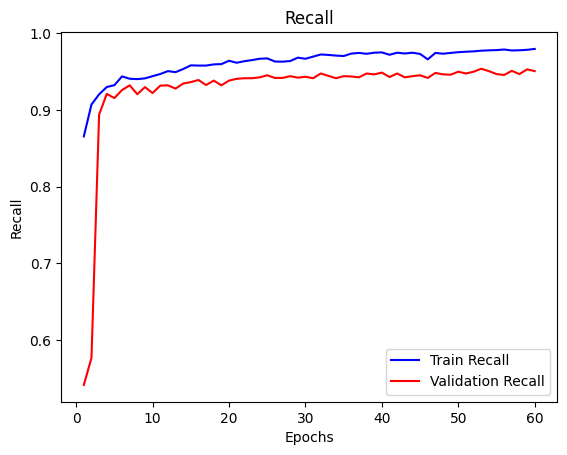

In [ ]:
# Получение значений метрики Recall на обучающем и валидационном наборах данных
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Получение значений эпох
epochs = range(1, len(train_recall) + 1)

# Визуализация метрики Recall
plt.plot(epochs, train_recall, 'b', label='Train Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

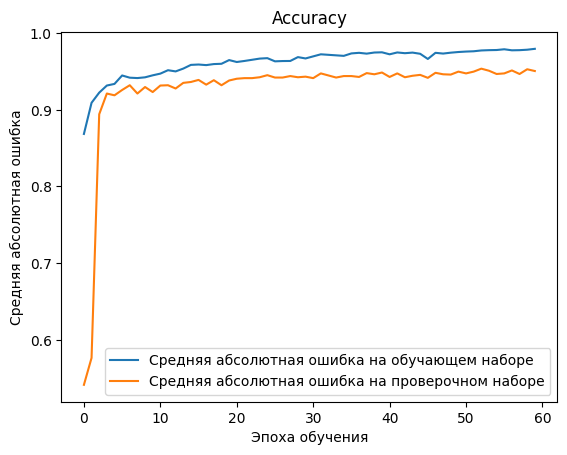

In [ ]:
plt.plot(history.history['accuracy'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.title('Accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# **Смотрим на результат работы по тестовым данным (которые сеть еще не видела при обучении), проценты точности**

In [ ]:
model=load_model("/content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5")

In [ ]:
accuracy = model.evaluate((x_test_age, x_test_fact, x_test_MKB, x_test_text_prof), y_test)
print("Accuracy:", accuracy)

31/31 [==============================] - 2s 40ms/step - loss: 0.5472 - recall: 0.9415 - accuracy: 0.9415
Accuracy: [0.5472294688224792, 0.9415384531021118, 0.9415384531021118]


In [ ]:
y_pred = model.predict((x_test_age, x_test_fact, x_test_MKB, x_test_text_prof))

31/31 [==============================] - 1s 27ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

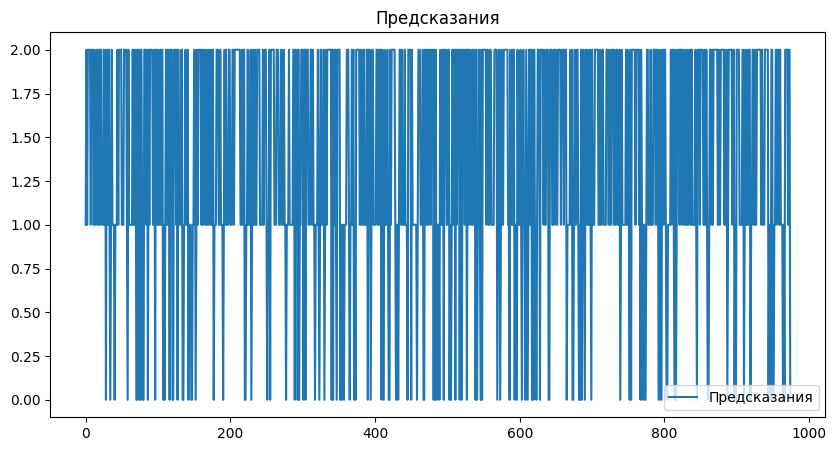

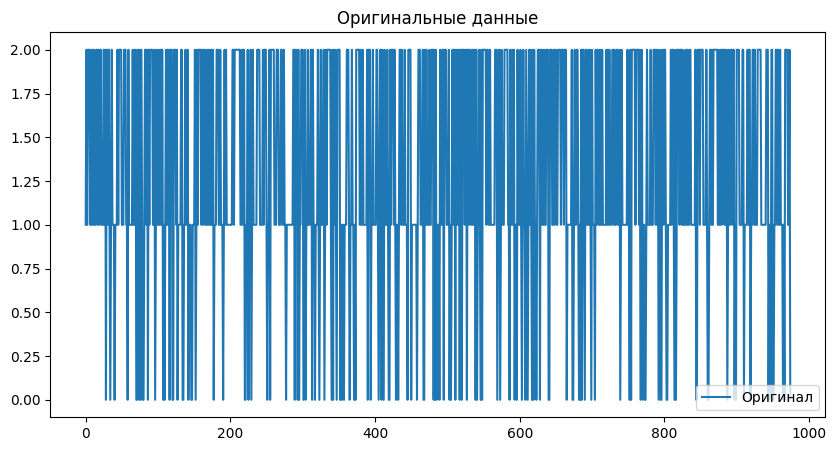

In [ ]:
#Визуализация предсказаний:
plt.figure(figsize=(10, 5))
plt.plot(y_pred_classes, label='Предсказания')
plt.legend()
plt.title('Предсказания')
plt.show()
#Визуализация оригинальных данных:
plt.figure(figsize=(10, 5))
plt.plot(y_test_encoded, label='Оригинал')
plt.legend()
plt.title('Оригинальные данные')
plt.show()

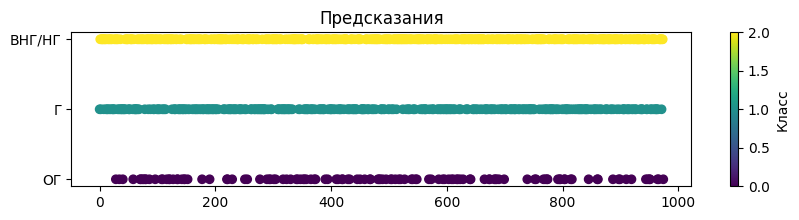

In [ ]:
# Визуализация предсказаний
plt.figure(figsize=(10, 2))
plt.scatter(range(len(y_pred_classes)), y_pred_classes, marker='o', c=y_pred_classes, cmap='viridis')
plt.yticks(range(len(class_labels)), class_labels.values())
plt.colorbar(label='Класс')
plt.title('Предсказания')
plt.show()

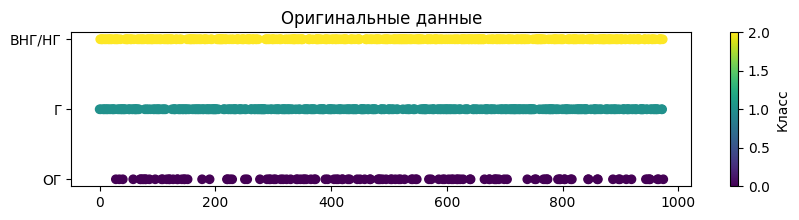

In [ ]:
# Визуализация оригинальных данных
plt.figure(figsize=(10, 2))
plt.scatter(range(len(y_test_encoded)), y_test_encoded, marker='o', c=y_test_encoded, cmap='viridis')
plt.yticks(range(len(class_labels)), class_labels.values())
plt.colorbar(label='Класс')
plt.title('Оригинальные данные')
plt.show()

In [ ]:
evaluation = model.evaluate((x_test_age, x_test_fact, x_test_MKB, x_test_text_prof), y_test)

31/31 [==============================] - 1s 31ms/step - loss: 0.5472 - recall: 0.9415 - accuracy: 0.9415


In [ ]:
accuracy = evaluation[1]

In [ ]:
print('Точность модели:', accuracy)

Точность модели: 0.9415384531021118


In [ ]:
print('Точность модели: %.2f%%' % (accuracy * 100))

Точность модели: 94.15%


In [ ]:
num_outputs = model.output_shape[-1]
print("Количество выходов модели:", num_outputs)

Количество выходов модели: 3


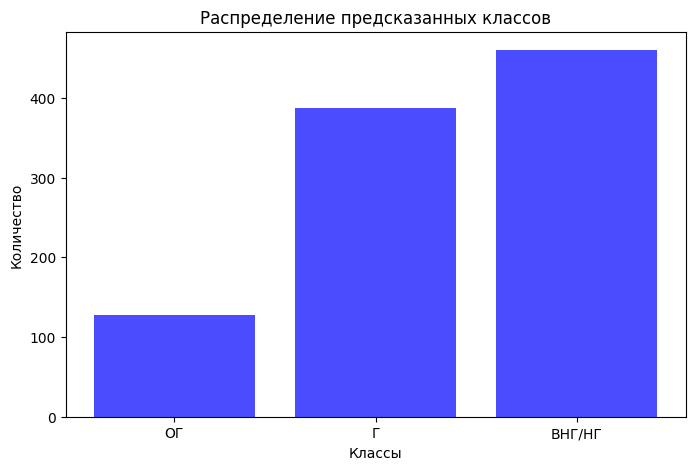

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(y_pred_classes, bins=np.arange(4)-0.5, align='mid', rwidth=0.8, color='blue', alpha=0.7)
plt.xticks(range(3), class_labels.values())
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

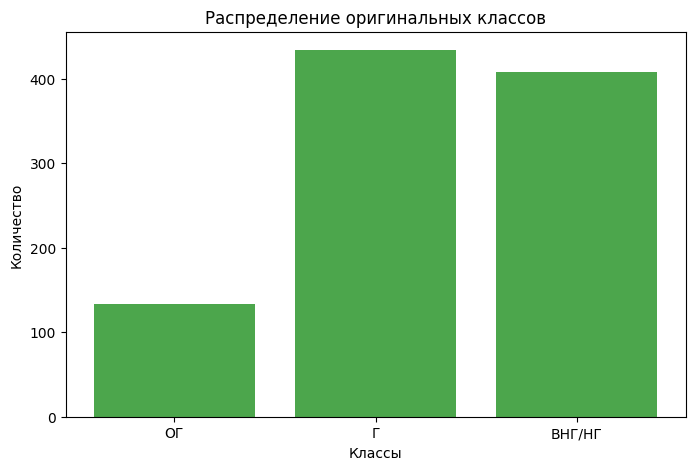

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(y_test_encoded, bins=np.arange(4)-0.5, align='mid', rwidth=0.8, color='green', alpha=0.7)
plt.xticks(range(3), class_labels.values())
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение оригинальных классов')
plt.show()

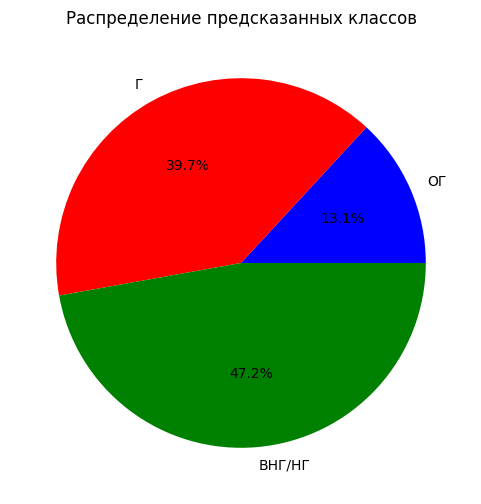

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(np.bincount(y_pred_classes), labels=class_labels.values(), autopct='%1.1f%%', colors=['blue', 'red', 'green'])
plt.title('Распределение предсказанных классов')
plt.show()

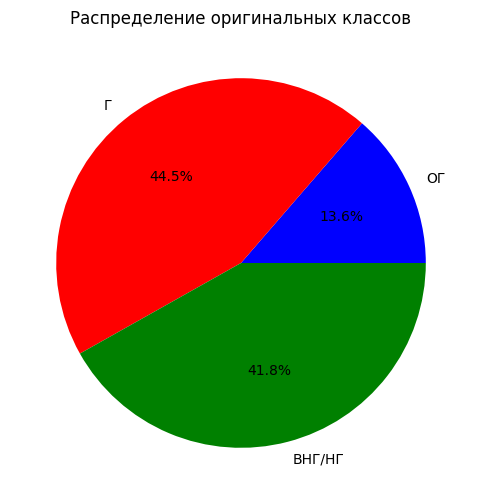

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(np.bincount(y_test_encoded), labels=class_labels.values(), autopct='%1.1f%%', colors=['blue', 'red', 'green'])
plt.title('Распределение оригинальных классов')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Округление предсказаний до ближайшего целого значения
rounded_predictions = np.argmax(predictions, axis=1)

# Создание матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1), rounded_predictions)

print(cm)

[[128   3   2]
 [  0 383  51]
 [  0   1 407]]


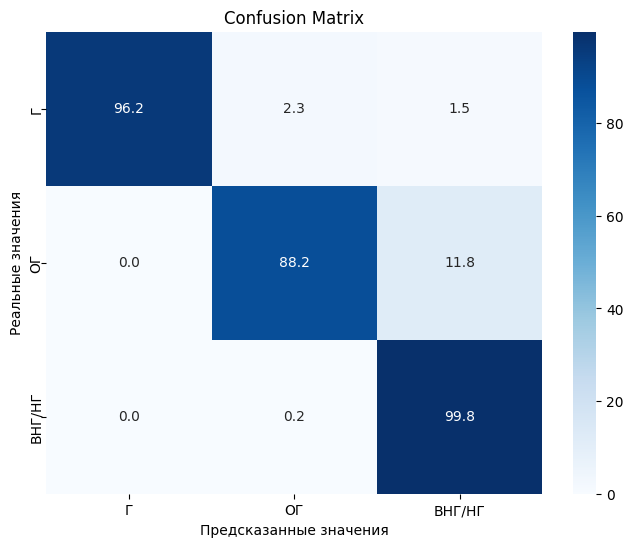

In [ ]:
# Создание списка текстовых меток классов
class_labels = ['Г', 'ОГ', 'ВНГ/НГ']

# Создание матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1), rounded_predictions)

# Расчет процентов точности
cm_percent = cm / np.sum(cm, axis=1).reshape(-1, 1) * 100

# Создание тепловой карты (heatmap) для визуализации матрицы ошибок с процентами
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Предсказанные значения")
plt.ylabel("Реальные значения")

# Замена значений на осях на текстовые метки с выравниванием по центру
ax.set_xticklabels(class_labels, ha='center')
ax.set_yticklabels(class_labels, ha='center')

plt.show()

В матрице выше мы видим точность предсказания модели по 3-м классам в процентах.

In [ ]:
dl_spavki = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/vred_fact(2).xlsx')

In [ ]:
dl_spavki = dl_spavki.astype(str)

In [ ]:
data_dict_str = dl_spavki.set_index('код')['описание'].to_dict()

In [ ]:
#data_dict_str = {key: str(value) for key, value in data_dict.items()}

In [ ]:
print("Ключи в data_dict_str:", data_dict_str.keys())

Ключи в data_dict_str: dict_keys(['1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1', '1.6', '1.7', '1.7.1', '1.7.2', '1.8', '1.8.1', '1.8.1.1', '1.8.1.2', '1.8.2', '1.8.2.1', '1.8.2.2', '1.8.3', '1.8.3.1', '1.8.3.2', '1.8.4', '1.8.4.1', '1.8.4.2', '1.9', '1.10', '1.11', '1.12', '1.13', '1.14', '1.14.1', '1.14.2', '1.15', '1.15.1', '1.16', '1.17', '1.18', '1.18.1', '1.18.2', '1.18.3', '1.19', '1.19.1', '1.19.2', '1.19.3', '1.20', '1.21', '1.22', '1.23', '1.24', '1.25', '1.26', '1.27', '1.27.1', '1.27.2', '1.28', '1.29', '1.29.1', '1.29.2', '1.29.3', '1.29.4', '1.29.5', '1.30', '1.30.1', '1.31', '1.32', '1.33', '1.34', '1.34.1', '1.34.2', '1.35', '1.36', '1.36.1', '1.36.2', '1.36.3', '1.37', '1.37.1', '1.37.1.1', '1.37.1.2', '1.37.2', '1.38', '1.39', '1.40', '1.40.1', '1.40.2', '1.41', '1.42', '1.43', '1.43.1', '1.43.2', '1.44', '1.45', '1.45.1', '1.45.2', '1.45.3', '1.46', '1.47', '1.47.1', '1.47.2', '1.47.3', '1.47.4', '1.47.5', '1.47.6', '1.47.7', '1.47.8', '1.47.9', '1.47.10', '1.47.11', '1

In [ ]:
# Выберите индекс примера, который хотите визуализировать
index = 0  # Замените это значение на нужный индекс

# Получение предсказания для выбранного примера
prediction = model.predict((x_test_age[index:index+1], x_test_fact[index:index+1],\
                            x_test_MKB[index:index+1], x_test_text_prof[index:index+1]))
predicted_classes = np.argmax(prediction, axis=1)
predicted_probabilities = np.max(prediction, axis=1)

# Получение входных данных для выбранного примера
input_data1 = x_test_age[index]
input_data2 = x_test_fact[index]
input_data3 = x_test_MKB[index]
input_data4 = x_test_text_prof[index]

# Получение классов и их меток из модели
class_labels = {idx: label for idx, label in enumerate(label_encoder.inverse_transform(np.arange(3)))}

predicted_labels = [class_labels[predicted_class] for predicted_class in predicted_classes]

# Получение МКБ из combined_df
client_prof = combined_df.loc[index, "Профессия"]
mkb = combined_df.loc[index, "МКБ"]
vred_fact = combined_df.loc[index, colms5]
vred_fact_columns = vred_fact[vred_fact == "1"].index.tolist()
vred_fact_labels = [data_dict_str.get(key) for key in vred_fact_columns]

#print("вредные факторы:", vred_fact_labels)

# Вывод результатов
print("_________________________________________________________________")
print("Предсказание модели и вероятности:")
for predicted_label, predicted_probability in zip(predicted_labels, predicted_probabilities):
    probability_percent = predicted_probability * 100
    print(f"Класс: {predicted_label}, Вероятность: {probability_percent:.2f}%")
print("МКБ (или список МКБ):", mkb)
print("_________________________________________________________________")
print("")
print("Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)")
print("")
for col, label in zip(vred_fact_columns, vred_fact_labels):
    print(f"{col} - {label}")
print("_________________________________________________________________")
print("Профессия клиента: ",client_prof)
print("_________________________________________________________________")
print("Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению")

1/1 [==============================] - 0s 127ms/step
_________________________________________________________________
Предсказание модели и вероятности:
Класс: Г, Вероятность: 100.00%
МКБ (или список МКБ): Z00.0
_________________________________________________________________

Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)

11.4 - Работы, выполняемые вахтовым методом в необжитых, отдаленных районах и районах с особыми природными условиями (в отношении проведения предварительных медицинских осмотров для работников, выполняющих работу вахтовым методом в указанных районах)
6.2 - Прочие работы, относящиеся в соответствии с законодательством по охране труда к работам на высоте
11.1 - Работы в нефтяной и газовой промышленности, выполняемые в районах Крайнего Севера и приравненных к ним местностях, а также при морском бурении
5.1 - Тяжесть трудового процесса Подъем, перемещение, удержание груза вручную Стереотипные рабочие

In [ ]:
# Задайте индекс примера, для которого вы хотите получить предсказание
index = 3  # Замените на нужный индекс

# Получение предсказания для выбранного примера
prediction = model.predict((x_test_ohe[index:index+1], x_test_fact[index:index+1],\
                            x_test_text_MKB[index:index+1],\
                            x_test_text_cex[index:index+1], x_test_prof[index:index+1]))
predicted_classes = np.argmax(prediction, axis=1)
predicted_probabilities = np.max(prediction, axis=1)

# Получение входных данных для выбранного примера
input_data1 = x_test_ohe[index]
input_data2 = x_test_fact[index]
input_data3 = x_test_text_MKB[index]
input_data5 = x_test_text_cex[index]
input_data6 = x_test_prof[index]

class_labels = {
    2: label_encoder.inverse_transform([2])[0],  # ОГ
    1: label_encoder.inverse_transform([1])[0],  # ВНГ
    0: label_encoder.inverse_transform([0])[0]   # Г
}

predicted_labels = [class_labels[predicted_class] for predicted_class in predicted_classes]

# Получение МКБ из combined_df
client_prof = combined_df.loc[index, "Профессия"]
mkb = combined_df.loc[index, "МКБ"]
vred_fact = combined_df.loc[index, colms5]
vred_fact_columns = vred_fact[vred_fact == "1"].index.tolist()
vred_fact_labels = [data_dict_str.get(key) for key in vred_fact_columns]

# Вывод результатов
print("_________________________________________________________________")
print("Предсказание модели и вероятности:")
for predicted_label, predicted_probability in zip(predicted_labels, predicted_probabilities):
    probability_percent = predicted_probability * 100
    print(f"Класс: {predicted_label}, Вероятность: {probability_percent:.2f}%")
print("МКБ (или список МКБ):", mkb)
print("_________________________________________________________________")
print("")
print("Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)")
print("")
for col, label in zip(vred_fact_columns, vred_fact_labels):
    print(f"{col} - {label}")
print("_________________________________________________________________")
print("Профессия клиента: ",client_prof)
print("_________________________________________________________________")
print("Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению")

1/1 [==============================] - 0s 41ms/step
_________________________________________________________________
Предсказание модели и вероятности:
Класс: ОГ, Вероятность: 76.20%
МКБ (или список МКБ): H52
_________________________________________________________________

Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)

6 - Работы на высоте:
4.7 - Параметры охлаждающего микроклимата (температура, влажность, скорость движения воздуха)
9 - Работы, связанные с техническим обслуживанием электроустановок напряжением 50 В и выше переменного тока и 75 В и выше постоянного тока, проведением в них оперативных переключений, выполнением строительных, монтажных, наладочных, ремонтных работ, испытанием и измерением
5.1 - Тяжесть трудового процесса Подъем, перемещение, удержание груза вручную Стереотипные рабочие движения
_________________________________________________________________
Профессия клиента:  Электромонтажник 
____

Функция которая берет случай по индексу таблицы и предоставляет по нему рекомендацию

In [ ]:
def getParameterAgeVect(arg):
    outClass = int((arg - 13) / 5)
    outClass = max(0, min(10, outClass))
    return outClass

def getAgeFromCategory(category):
    age = int(category) * 5 + 13
    return age

def visualize_prediction(index):
    # Получение предсказания для выбранного примера
    prediction = model.predict((x_test_age[index:index+1], x_test_fact[index:index+1],\
                                x_test_MKB[index:index+1], x_test_text_prof[index:index+1]))
    predicted_classes = np.argmax(prediction, axis=1)
    predicted_probabilities = np.max(prediction, axis=1)

    # Получение входных данных для выбранного примера
    input_data1 = x_test_age[index]
    input_data2 = x_test_fact[index]
    input_data3 = x_test_MKB[index]
    input_data4 = x_test_text_prof[index]

    # Получение классов и их меток из модели
    class_labels = {idx: label for idx, label in enumerate(label_encoder.inverse_transform(np.arange(3)))}

    predicted_labels = [class_labels[predicted_class] for predicted_class in predicted_classes]

    # Получение МКБ из combined_df
    client_prof = combined_df.loc[index, "Профессия"]
    mkb = combined_df.loc[index, "МКБ"]
    vred_fact = combined_df.loc[index, colms5]
    vred_fact_columns = vred_fact[vred_fact == "1"].index.tolist()
    vred_fact_labels = [data_dict_str.get(key) for key in vred_fact_columns]

    # Получение возраста клиента из категории
    age_category = combined_df.loc[index, "ВозрастКатегория"]
    age = getAgeFromCategory(age_category)

    # Вывод результатов
    print("_________________________________________________________________")
    print("Предсказание модели и вероятности:")
    for predicted_label, predicted_probability in zip(predicted_labels, predicted_probabilities):
        probability_percent = predicted_probability * 100
        print(f"Класс: {predicted_label}, Вероятность: {probability_percent:.2f}%")
    print("МКБ (или список МКБ):", mkb)
    print("_________________________________________________________________")
    print("")
    print("Вредные факторы и виды работ, которые, при наличии соответствующего диагноза, могут препятствовать деятельности на данном производстве данному пациенту(ке)")
    print("")
    for col, label in zip(vred_fact_columns, vred_fact_labels):
        print(f"{col} - {label}")
    print("_________________________________________________________________")
    print("Профессия клиента: ", client_prof)
    print("Возраст: ", age)
    print("_________________________________________________________________")
    print("Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению")

# Использование функции для получения предсказания по заданному индексу
index = 0  # Замените на нужный индекс
visualize_prediction(index)

1/1 [==============================] - 0s 27ms/step
_________________________________________________________________
Предсказание модели и вероятности:
Класс: Г, Вероятность: 100.00%
МКБ (или список МКБ): Z00.0
_________________________________________________________________

Вредные факторы и виды работ, которые, при наличии соответствующего диагноза, могут препятствовать деятельности на данном производстве данному пациенту(ке)

11.4 - Работы, выполняемые вахтовым методом в необжитых, отдаленных районах и районах с особыми природными условиями (в отношении проведения предварительных медицинских осмотров для работников, выполняющих работу вахтовым методом в указанных районах)
6.2 - Прочие работы, относящиеся в соответствии с законодательством по охране труда к работам на высоте
11.1 - Работы в нефтяной и газовой промышленности, выполняемые в районах Крайнего Севера и приравненных к ним местностях, а также при морском бурении
5.1 - Тяжесть трудового процесса Подъем, перемещение, удерж

# **Тест системы**
Введите ваше число в скобки для получения предсказания по индексу из таблицы

In [ ]:
visualize_prediction(77)

1/1 [==============================] - 0s 101ms/step
_________________________________________________________________
Предсказание модели и вероятности:
Класс: ОГ, Вероятность: 100.00%
МКБ (или список МКБ): H52.1
_________________________________________________________________

Вредные факторы и виды работ, которые, при наличии соответствующего диагноза, могут препятствовать деятельности на данном производстве данному пациенту(ке)

23 - Работы, где имеется контакт с пищевыми продуктами в процессе их производства, хранения, транспортировки и реализации (в организациях пищевых и перерабатывающих отраслей промышленности, сельского хозяйства, пунктах, базах, складах хранения и реализации, в транспортных организациях, организациях торговли, общественного питания, на пищеблоках всех учреждений и организаций)
18.1 - Категории "A", "B", "BE", трактора и другие самоходные машины, мини-трактора, мотоблоки, автопогрузчики, электрокары, регулировщики и т.п., автомобили всех категорий с ручным уп

модель получает данные из combined_df содержащую таблицу заказчика, и добавочную таблицу из приказа н29. Для предсказания нужна таблица сделанная по подобию combined_df. подаются текстовые данные далее получается предсказание

# **Выводы, Резюме, Предложения**

В ходе экспериментов, было создано большое кол-во моделей достигавших заявленной точности (или ниже), в том числе модели с использованием Embedding и LSTM, финальный вариант модели показавший лучшую точность НС представлен выше.
Модель предсказывает годных (Г) с вероятностью ~97 %, временно негодных (ВНГ) и негодных (НГ) ~99 %, ограниченно годных (ОГ) ~88 %, а также выводит на экран дополнительную информацию по факторам риска и ключевому(-ым) МКБ (заголовкам МКБ). Таким образом основная цель (Цель: Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.) считаю выполненной.
При разъяснении нейронной сети нюансов каким образом происходит подразделение на еще и ограниченно годных возможно улучшение работы модели (Улучшение моей  таблицы на основе приказа н29). Или же при достаточной базе данных от 5 000 примеров профпатологов по каждому из классов (на данный момент из около 30000 примеров после очистки от мусора непригодного для использования только 1000 примеров ОГ и около 100 НГ остальные десятки тысяч примеров либо без заключения либо годные) не годен и ограниченно годен появится возможность обучить модель без искусственного изменения за счет данных из приказа. В случае дальнейшего сотрудничества готов помочь с интеграцией модели в систему заказчика.

- Все также необходимо получить дата-сет с данными с большим кол-вом примеров для классов ограниченно годен и временно негоден (негоден) пока они представлены малым кол-вом примеров (разбалансированы) - иначе нейронную сеть не обучить должным образом. Без конкретных примеров она будет продолжать делать ошибки на классе "ограничено годен", что с медицинской точки зрения неприемлемо.

- При поддержке профпатолога необходимо подробнее разобрать приказ н29 для получения четкого понимания как распределять пациентов на ограниченно годных и негодных для дальнейшей искусственной аугментации данных критериями отбора, это позволит прогнозировать редкие случаи.

- Рекомендательную систему при большем кол-ве примеров можно попытаться  улучшить, к примеру создав отдельно НС для ОГ и НГ для разъяснения по этим классам причины негодности. К примеру для начала добиться отличных результатов по классификации на 2 класса (годные, все остальные), а затем пропускать классифицированный пример через другой модуль НС для описания этого конкретного случая.